In [1]:
#=======================================
## DNN - Haberman
#=======================================

# Need compile Create_DNN_model.

#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#----------------------------------------
# Load the Haberman Survival dataset.

dataset = np.loadtxt("Haberman-Survival-Data.txt", delimiter = ",")

print(type(dataset))

print(dataset.shape)

# Split the data into input (X) and output (Y) variables.

X = dataset[:, 0:3]
Y = np.array(dataset[:, 3], dtype = int)

print(np.unique(Y))

print(X.shape)
print(Y.shape)


<class 'numpy.ndarray'>
(306, 4)
[1 2]
(306, 3)
(306,)


In [3]:
#----------------------------------------
# Change the output label to 0 and 1.

Y_train = np.copy(Y)
index = np.where(Y_train == 2)
Y_train[index] = 0

print(np.unique(Y_train))


[0 1]


In [4]:
#----------------------------------------
# Standardize the input data.

sample_mean = np.mean(X, axis = 0)
print(np.round(sample_mean, 4))

sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

print(np.round(np.mean(X_train, axis = 0), 4))
print(np.round(np.std(X_train, axis = 0, ddof = 1), 4))


[52.4575 62.8529  4.0261]
[10.8035  3.2494  7.1897]
[ 0.  0. -0.]
[1. 1. 1.]


In [5]:
#----------------------------------------
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [6]:
## Create DNN model

def create_DNN_model(nodes, drop, kernel, act):
  model = Sequential()
  # Build input_layer & first_hidden_layer
  if drop[0] > 0:
    model.add(Dropout(rate = drop[0], input_shape = (nodes[0], )))
    model.add(Dense(units = nodes[1], kernel_initializer = kernel[0], activation =act[0]))
    if drop[1] > 0:
      model.add(Dropout(rate = drop[1]))
  else:
    model.add(Dense(units = nodes[1], input_dim = nodes[0], kernel_initializer = kernel[0], activation =act[0]))
    if drop[1] > 0:
      model.add(Dropout(rate = drop[1]))
  # Build other_hidden_layer
  for i in range(2, len(nodes) - 1):
    model.add(Dense(units = nodes[i], kernel_initializer = kernel[i-1], activation =act[i-1]))
    if drop[i] > 0:
      model.add(Dropout(rate = drop[i]))
  # Build output_layer
  model.add(Dense(units = nodes[len(nodes)-1], kernel_initializer = kernel[len(kernel) - 1], activation = act[len(act) - 1]))
  return model

In [7]:
#----------------------------------------
# Create the DNN_model

input_dim = X.shape[1]

nodes = [input_dim, 5, 6, 4, 1]
	# first component: number of input nodes
	# last component: number of output nodes

drop = [0, 0.1, 0.1, 0.1]
	# len(dropout_rate) = len(node) - 1
	# first component: dropout rate for the input layer
	# other components: dropout rates for the hidden layers
	# Dropout rate is not used in the output layer.

#dropout_rate = [0]*(len(node)-1)
#dropout_rate = [0] + [0.2]*(len(node)-2)

kernel = ['uniform', 'uniform', 'uniform', 'uniform']

act = ['relu', 'relu', 'relu', 'sigmoid']


In [8]:
#----------------------------------------
# 10-fold cross validation

cv_bc = []
cv_acc = []

for k in range(fold_num):
    # Build the model.
    model = create_DNN_model(nodes, drop, kernel, act)
    # Compile the model.
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit(X_train[train_index], Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 40, verbose = 1)
    # Evaluate the model.
    scores = model.evaluate(X_train[test_index], Y_train[test_index], verbose = 1)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_bc.append(scores[0])
    cv_acc.append(scores[1])


Train on 220 samples, validate on 55 samples
Epoch 1/1000
220/220 [==============================] - 1s 3ms/step - loss: 0.6926 - acc: 0.6182 - val_loss: 0.6915 - val_acc: 0.7818
Epoch 2/1000
220/220 [==============================] - 0s 102us/step - loss: 0.6913 - acc: 0.7273 - val_loss: 0.6899 - val_acc: 0.7818
Epoch 3/1000
220/220 [==============================] - 0s 120us/step - loss: 0.6901 - acc: 0.7273 - val_loss: 0.6883 - val_acc: 0.7818
Epoch 4/1000
220/220 [==============================] - 0s 125us/step - loss: 0.6888 - acc: 0.7273 - val_loss: 0.6867 - val_acc: 0.7818
Epoch 5/1000
220/220 [==============================] - 0s 109us/step - loss: 0.6875 - acc: 0.7273 - val_loss: 0.6851 - val_acc: 0.7818
Epoch 6/1000
220/220 [==============================] - 0s 101us/step - loss: 0.6863 - acc: 0.7273 - val_loss: 0.6836 - val_acc: 0.7818
Epoch 7/1000
220/220 [==============================] - 0s 102us/step - loss: 0.6850 - acc: 0.7273 - val_loss: 0.6821 - val_acc: 0.7818
Epoch

220/220 [==============================] - 0s 166us/step - loss: 0.6350 - acc: 0.7273 - val_loss: 0.6177 - val_acc: 0.7818
Epoch 61/1000
220/220 [==============================] - 0s 115us/step - loss: 0.6343 - acc: 0.7273 - val_loss: 0.6167 - val_acc: 0.7818
Epoch 62/1000
220/220 [==============================] - 0s 114us/step - loss: 0.6337 - acc: 0.7273 - val_loss: 0.6158 - val_acc: 0.7818
Epoch 63/1000
220/220 [==============================] - 0s 100us/step - loss: 0.6330 - acc: 0.7273 - val_loss: 0.6149 - val_acc: 0.7818
Epoch 64/1000
220/220 [==============================] - 0s 111us/step - loss: 0.6324 - acc: 0.7273 - val_loss: 0.6140 - val_acc: 0.7818
Epoch 65/1000
220/220 [==============================] - 0s 97us/step - loss: 0.6317 - acc: 0.7273 - val_loss: 0.6131 - val_acc: 0.7818
Epoch 66/1000
220/220 [==============================] - 0s 100us/step - loss: 0.6311 - acc: 0.7273 - val_loss: 0.6122 - val_acc: 0.7818
Epoch 67/1000
220/220 [==============================] -

Epoch 120/1000
220/220 [==============================] - 0s 166us/step - loss: 0.6057 - acc: 0.7273 - val_loss: 0.5755 - val_acc: 0.7818
Epoch 121/1000
220/220 [==============================] - 0s 128us/step - loss: 0.6054 - acc: 0.7273 - val_loss: 0.5751 - val_acc: 0.7818
Epoch 122/1000
220/220 [==============================] - 0s 118us/step - loss: 0.6051 - acc: 0.7273 - val_loss: 0.5746 - val_acc: 0.7818
Epoch 123/1000
220/220 [==============================] - 0s 118us/step - loss: 0.6048 - acc: 0.7273 - val_loss: 0.5741 - val_acc: 0.7818
Epoch 124/1000
220/220 [==============================] - 0s 108us/step - loss: 0.6045 - acc: 0.7273 - val_loss: 0.5736 - val_acc: 0.7818
Epoch 125/1000
220/220 [==============================] - 0s 86us/step - loss: 0.6042 - acc: 0.7273 - val_loss: 0.5731 - val_acc: 0.7818
Epoch 126/1000
220/220 [==============================] - 0s 108us/step - loss: 0.6039 - acc: 0.7273 - val_loss: 0.5726 - val_acc: 0.7818
Epoch 127/1000
220/220 [===========

220/220 [==============================] - 0s 102us/step - loss: 0.5931 - acc: 0.7273 - val_loss: 0.5538 - val_acc: 0.7818
Epoch 180/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5930 - acc: 0.7273 - val_loss: 0.5536 - val_acc: 0.7818
Epoch 181/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5929 - acc: 0.7273 - val_loss: 0.5534 - val_acc: 0.7818
Epoch 182/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5928 - acc: 0.7273 - val_loss: 0.5531 - val_acc: 0.7818
Epoch 183/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5926 - acc: 0.7273 - val_loss: 0.5529 - val_acc: 0.7818
Epoch 184/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5925 - acc: 0.7273 - val_loss: 0.5526 - val_acc: 0.7818
Epoch 185/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5924 - acc: 0.7273 - val_loss: 0.5524 - val_acc: 0.7818
Epoch 186/1000
220/220 [=========================

220/220 [==============================] - 0s 160us/step - loss: 0.5882 - acc: 0.7273 - val_loss: 0.5427 - val_acc: 0.7818
Epoch 239/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5882 - acc: 0.7273 - val_loss: 0.5426 - val_acc: 0.7818
Epoch 240/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5881 - acc: 0.7273 - val_loss: 0.5425 - val_acc: 0.7818
Epoch 241/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5881 - acc: 0.7273 - val_loss: 0.5424 - val_acc: 0.7818
Epoch 242/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5880 - acc: 0.7273 - val_loss: 0.5423 - val_acc: 0.7818
Epoch 243/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5880 - acc: 0.7273 - val_loss: 0.5421 - val_acc: 0.7818
Epoch 244/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5879 - acc: 0.7273 - val_loss: 0.5420 - val_acc: 0.7818
Epoch 245/1000
220/220 [=========================

220/220 [==============================] - 0s 132us/step - loss: 0.5866 - acc: 0.7273 - val_loss: 0.5374 - val_acc: 0.7818
Epoch 298/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5866 - acc: 0.7273 - val_loss: 0.5373 - val_acc: 0.7818
Epoch 299/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5866 - acc: 0.7273 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 300/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5866 - acc: 0.7273 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 301/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5865 - acc: 0.7273 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 302/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5865 - acc: 0.7273 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 303/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5865 - acc: 0.7273 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 304/1000
220/220 [=========================

220/220 [==============================] - 0s 108us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5347 - val_acc: 0.7818
Epoch 357/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 358/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 359/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 360/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 361/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 362/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 363/1000
220/220 [=========================

220/220 [==============================] - 0s 167us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 416/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 417/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 418/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 419/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 420/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 421/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5336 - val_acc: 0.7818
Epoch 422/1000
220/220 [=========================

220/220 [==============================] - 0s 95us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 475/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 476/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 477/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 478/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 479/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 480/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 481/1000
220/220 [===========================

220/220 [==============================] - 0s 105us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5323 - val_acc: 0.7818
Epoch 534/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5323 - val_acc: 0.7818
Epoch 535/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5323 - val_acc: 0.7818
Epoch 536/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 537/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 538/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 539/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 540/1000
220/220 [==========================

220/220 [==============================] - 0s 154us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 593/1000
220/220 [==============================] - 0s 196us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5323 - val_acc: 0.7818
Epoch 594/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 595/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 596/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5323 - val_acc: 0.7818
Epoch 597/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 598/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 599/1000
220/220 [==========================

220/220 [==============================] - 0s 106us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 652/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 653/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 654/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 655/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 656/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 657/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 658/1000
220/220 [=========================

220/220 [==============================] - 0s 134us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 711/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 712/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 713/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5328 - val_acc: 0.7818
Epoch 714/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 715/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 716/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 717/1000
220/220 [==========================

220/220 [==============================] - 0s 96us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 770/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 771/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5327 - val_acc: 0.7818
Epoch 772/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 773/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 774/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 775/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 776/1000
220/220 [==============================

220/220 [==============================] - 0s 67us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 829/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 830/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 831/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 832/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 833/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 834/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 835/1000
220/220 [============================

220/220 [==============================] - 0s 88us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 888/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 889/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 890/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 891/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 892/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 893/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7818
Epoch 894/1000
220/220 [===========================

Epoch 947/1000
220/220 [==============================] - 0s 64us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 948/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 949/1000
220/220 [==============================] - 0s 53us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 950/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5324 - val_acc: 0.7818
Epoch 951/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 952/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 953/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5860 - acc: 0.7273 - val_loss: 0.5325 - val_acc: 0.7818
Epoch 954/1000
220/220 [=============

Epoch 6/1000
220/220 [==============================] - 0s 119us/step - loss: 0.6849 - acc: 0.7273 - val_loss: 0.6815 - val_acc: 0.7818
Epoch 7/1000
220/220 [==============================] - 0s 131us/step - loss: 0.6831 - acc: 0.7273 - val_loss: 0.6791 - val_acc: 0.7818
Epoch 8/1000
220/220 [==============================] - 0s 102us/step - loss: 0.6814 - acc: 0.7273 - val_loss: 0.6766 - val_acc: 0.7818
Epoch 9/1000
220/220 [==============================] - 0s 116us/step - loss: 0.6792 - acc: 0.7273 - val_loss: 0.6740 - val_acc: 0.7818
Epoch 10/1000
220/220 [==============================] - 0s 105us/step - loss: 0.6771 - acc: 0.7273 - val_loss: 0.6713 - val_acc: 0.7818
Epoch 11/1000
220/220 [==============================] - 0s 112us/step - loss: 0.6751 - acc: 0.7273 - val_loss: 0.6683 - val_acc: 0.7818
Epoch 12/1000
220/220 [==============================] - 0s 106us/step - loss: 0.6723 - acc: 0.7273 - val_loss: 0.6648 - val_acc: 0.7818
Epoch 13/1000
220/220 [======================

Epoch 66/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5620 - acc: 0.7273 - val_loss: 0.4846 - val_acc: 0.7818
Epoch 67/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5683 - acc: 0.7273 - val_loss: 0.4832 - val_acc: 0.7818
Epoch 68/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5711 - acc: 0.7273 - val_loss: 0.4826 - val_acc: 0.7818
Epoch 69/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5631 - acc: 0.7273 - val_loss: 0.4822 - val_acc: 0.7818
Epoch 70/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5616 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7818
Epoch 71/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5785 - acc: 0.7273 - val_loss: 0.4813 - val_acc: 0.7818
Epoch 72/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5767 - acc: 0.7273 - val_loss: 0.4823 - val_acc: 0.7818
Epoch 73/1000
220/220 [=======================

Epoch 126/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5641 - acc: 0.7273 - val_loss: 0.4748 - val_acc: 0.7818
Epoch 127/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5761 - acc: 0.7273 - val_loss: 0.4763 - val_acc: 0.7818
Epoch 128/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5631 - acc: 0.7273 - val_loss: 0.4775 - val_acc: 0.7818
Epoch 129/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5540 - acc: 0.7273 - val_loss: 0.4775 - val_acc: 0.7818
Epoch 130/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5510 - acc: 0.7273 - val_loss: 0.4763 - val_acc: 0.7818
Epoch 131/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5558 - acc: 0.7273 - val_loss: 0.4756 - val_acc: 0.7818
Epoch 132/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5604 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7818
Epoch 133/1000
220/220 [===========

220/220 [==============================] - 0s 153us/step - loss: 0.5613 - acc: 0.7273 - val_loss: 0.4622 - val_acc: 0.7818
Epoch 186/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5534 - acc: 0.7273 - val_loss: 0.4623 - val_acc: 0.7818
Epoch 187/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4609 - val_acc: 0.7818
Epoch 188/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5601 - acc: 0.7273 - val_loss: 0.4616 - val_acc: 0.7818
Epoch 189/1000
220/220 [==============================] - 0s 203us/step - loss: 0.5421 - acc: 0.7273 - val_loss: 0.4614 - val_acc: 0.7818
Epoch 190/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4612 - val_acc: 0.7818
Epoch 191/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5495 - acc: 0.7273 - val_loss: 0.4629 - val_acc: 0.7818
Epoch 192/1000
220/220 [=========================

220/220 [==============================] - 0s 124us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4570 - val_acc: 0.7818
Epoch 245/1000
220/220 [==============================] - 0s 190us/step - loss: 0.5398 - acc: 0.7273 - val_loss: 0.4567 - val_acc: 0.7818
Epoch 246/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5476 - acc: 0.7273 - val_loss: 0.4573 - val_acc: 0.7818
Epoch 247/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5608 - acc: 0.7273 - val_loss: 0.4583 - val_acc: 0.7818
Epoch 248/1000
220/220 [==============================] - ETA: 0s - loss: 0.4549 - acc: 0.775 - 0s 126us/step - loss: 0.5575 - acc: 0.7273 - val_loss: 0.4576 - val_acc: 0.7818
Epoch 249/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5574 - acc: 0.7273 - val_loss: 0.4583 - val_acc: 0.7818
Epoch 250/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5647 - acc: 0.7273 - val_loss: 0.4600 - val_acc: 0.7818
Epoch 251/100

220/220 [==============================] - 0s 132us/step - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4575 - val_acc: 0.7818
Epoch 304/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5582 - acc: 0.7273 - val_loss: 0.4580 - val_acc: 0.7818
Epoch 305/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5589 - acc: 0.7273 - val_loss: 0.4581 - val_acc: 0.7818
Epoch 306/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5412 - acc: 0.7273 - val_loss: 0.4587 - val_acc: 0.7818
Epoch 307/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5260 - acc: 0.7273 - val_loss: 0.4561 - val_acc: 0.7818
Epoch 308/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5522 - acc: 0.7273 - val_loss: 0.4549 - val_acc: 0.7818
Epoch 309/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5478 - acc: 0.7273 - val_loss: 0.4540 - val_acc: 0.7818
Epoch 310/1000
220/220 [=============================

220/220 [==============================] - 0s 99us/step - loss: 0.5476 - acc: 0.7273 - val_loss: 0.4558 - val_acc: 0.7818
Epoch 363/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5426 - acc: 0.7273 - val_loss: 0.4549 - val_acc: 0.7818
Epoch 364/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5767 - acc: 0.7273 - val_loss: 0.4553 - val_acc: 0.7818
Epoch 365/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5530 - acc: 0.7273 - val_loss: 0.4561 - val_acc: 0.7818
Epoch 366/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5568 - acc: 0.7273 - val_loss: 0.4568 - val_acc: 0.7818
Epoch 367/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5603 - acc: 0.7273 - val_loss: 0.4594 - val_acc: 0.7818
Epoch 368/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5564 - acc: 0.7273 - val_loss: 0.4605 - val_acc: 0.7818
Epoch 369/1000
220/220 [=============================

220/220 [==============================] - 0s 104us/step - loss: 0.5507 - acc: 0.7273 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 422/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5643 - acc: 0.7273 - val_loss: 0.4511 - val_acc: 0.7818
Epoch 423/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5576 - acc: 0.7273 - val_loss: 0.4516 - val_acc: 0.7818
Epoch 424/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5668 - acc: 0.7273 - val_loss: 0.4533 - val_acc: 0.7818
Epoch 425/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5582 - acc: 0.7273 - val_loss: 0.4557 - val_acc: 0.7818
Epoch 426/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5487 - acc: 0.7273 - val_loss: 0.4571 - val_acc: 0.7818
Epoch 427/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5510 - acc: 0.7273 - val_loss: 0.4590 - val_acc: 0.7818
Epoch 428/1000
220/220 [==========================

220/220 [==============================] - 0s 113us/step - loss: 0.5390 - acc: 0.7273 - val_loss: 0.4590 - val_acc: 0.7818
Epoch 481/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5403 - acc: 0.7273 - val_loss: 0.4576 - val_acc: 0.7818
Epoch 482/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5628 - acc: 0.7273 - val_loss: 0.4560 - val_acc: 0.7818
Epoch 483/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5549 - acc: 0.7273 - val_loss: 0.4548 - val_acc: 0.7818
Epoch 484/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4548 - val_acc: 0.7818
Epoch 485/1000
220/220 [==============================] - 0s 69us/step - loss: 0.5247 - acc: 0.7273 - val_loss: 0.4533 - val_acc: 0.7818
Epoch 486/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5447 - acc: 0.7273 - val_loss: 0.4535 - val_acc: 0.7818
Epoch 487/1000
220/220 [============================

Epoch 540/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5576 - acc: 0.7273 - val_loss: 0.4580 - val_acc: 0.7818
Epoch 541/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5404 - acc: 0.7273 - val_loss: 0.4572 - val_acc: 0.7818
Epoch 542/1000
220/220 [==============================] - 0s 73us/step - loss: 0.5375 - acc: 0.7273 - val_loss: 0.4553 - val_acc: 0.7818
Epoch 543/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5549 - acc: 0.7273 - val_loss: 0.4558 - val_acc: 0.7818
Epoch 544/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5431 - acc: 0.7273 - val_loss: 0.4550 - val_acc: 0.7818
Epoch 545/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5417 - acc: 0.7273 - val_loss: 0.4536 - val_acc: 0.7818
Epoch 546/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5513 - acc: 0.7273 - val_loss: 0.4520 - val_acc: 0.7818
Epoch 547/1000
220/220 [===============

220/220 [==============================] - 0s 109us/step - loss: 0.5460 - acc: 0.7273 - val_loss: 0.4535 - val_acc: 0.7818
Epoch 600/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5455 - acc: 0.7273 - val_loss: 0.4519 - val_acc: 0.7818
Epoch 601/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5627 - acc: 0.7273 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 602/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5355 - acc: 0.7273 - val_loss: 0.4524 - val_acc: 0.7818
Epoch 603/1000
220/220 [==============================] - 0s 70us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 604/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5378 - acc: 0.7273 - val_loss: 0.4527 - val_acc: 0.7818
Epoch 605/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5556 - acc: 0.7273 - val_loss: 0.4536 - val_acc: 0.7818
Epoch 606/1000
220/220 [==============================

Epoch 659/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5680 - acc: 0.7273 - val_loss: 0.4521 - val_acc: 0.7818
Epoch 660/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5561 - acc: 0.7273 - val_loss: 0.4527 - val_acc: 0.7818
Epoch 661/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5383 - acc: 0.7273 - val_loss: 0.4528 - val_acc: 0.7818
Epoch 662/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5507 - acc: 0.7273 - val_loss: 0.4537 - val_acc: 0.7818
Epoch 663/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5487 - acc: 0.7273 - val_loss: 0.4543 - val_acc: 0.7818
Epoch 664/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5412 - acc: 0.7273 - val_loss: 0.4551 - val_acc: 0.7818
Epoch 665/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5563 - acc: 0.7273 - val_loss: 0.4552 - val_acc: 0.7818
Epoch 666/1000
220/220 [============

220/220 [==============================] - 0s 138us/step - loss: 0.5549 - acc: 0.7273 - val_loss: 0.4572 - val_acc: 0.7818
Epoch 719/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5442 - acc: 0.7273 - val_loss: 0.4554 - val_acc: 0.7818
Epoch 720/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5632 - acc: 0.7273 - val_loss: 0.4545 - val_acc: 0.7818
Epoch 721/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5463 - acc: 0.7273 - val_loss: 0.4544 - val_acc: 0.7818
Epoch 722/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5491 - acc: 0.7273 - val_loss: 0.4540 - val_acc: 0.7818
Epoch 723/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5525 - acc: 0.7273 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 724/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5560 - acc: 0.7273 - val_loss: 0.4523 - val_acc: 0.7818
Epoch 725/1000
220/220 [=========================

220/220 [==============================] - 0s 105us/step - loss: 0.5409 - acc: 0.7273 - val_loss: 0.4538 - val_acc: 0.7818
Epoch 778/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5656 - acc: 0.7273 - val_loss: 0.4542 - val_acc: 0.7818
Epoch 779/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5653 - acc: 0.7273 - val_loss: 0.4550 - val_acc: 0.7818
Epoch 780/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4525 - val_acc: 0.7818
Epoch 781/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5462 - acc: 0.7273 - val_loss: 0.4517 - val_acc: 0.7818
Epoch 782/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5592 - acc: 0.7273 - val_loss: 0.4519 - val_acc: 0.7818
Epoch 783/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5623 - acc: 0.7273 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 784/1000
220/220 [==========================

220/220 [==============================] - 0s 121us/step - loss: 0.5508 - acc: 0.7273 - val_loss: 0.4503 - val_acc: 0.7818
Epoch 837/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5516 - acc: 0.7273 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 838/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5624 - acc: 0.7273 - val_loss: 0.4507 - val_acc: 0.7818
Epoch 839/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5581 - acc: 0.7273 - val_loss: 0.4521 - val_acc: 0.7818
Epoch 840/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5517 - acc: 0.7273 - val_loss: 0.4516 - val_acc: 0.7818
Epoch 841/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5451 - acc: 0.7273 - val_loss: 0.4512 - val_acc: 0.7818
Epoch 842/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4516 - val_acc: 0.7818
Epoch 843/1000
220/220 [=========================

220/220 [==============================] - 0s 116us/step - loss: 0.5504 - acc: 0.7273 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 896/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5435 - acc: 0.7273 - val_loss: 0.4493 - val_acc: 0.7818
Epoch 897/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5454 - acc: 0.7273 - val_loss: 0.4486 - val_acc: 0.7818
Epoch 898/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5483 - acc: 0.7273 - val_loss: 0.4478 - val_acc: 0.7818
Epoch 899/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5548 - acc: 0.7273 - val_loss: 0.4471 - val_acc: 0.7818
Epoch 900/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5441 - acc: 0.7273 - val_loss: 0.4461 - val_acc: 0.7818
Epoch 901/1000
220/220 [==============================] - ETA: 0s - loss: 0.6346 - acc: 0.700 - 0s 153us/step - loss: 0.5544 - acc: 0.7273 - val_loss: 0.4471 - val_acc: 0.7818
Epoch 902/10

Epoch 954/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5475 - acc: 0.7273 - val_loss: 0.4511 - val_acc: 0.7818
Epoch 955/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5541 - acc: 0.7273 - val_loss: 0.4504 - val_acc: 0.7818
Epoch 956/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5611 - acc: 0.7273 - val_loss: 0.4501 - val_acc: 0.7818
Epoch 957/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5624 - acc: 0.7273 - val_loss: 0.4491 - val_acc: 0.7818
Epoch 958/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5571 - acc: 0.7273 - val_loss: 0.4489 - val_acc: 0.7818
Epoch 959/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5471 - acc: 0.7273 - val_loss: 0.4491 - val_acc: 0.7818
Epoch 960/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5436 - acc: 0.7273 - val_loss: 0.4491 - val_acc: 0.7818
Epoch 961/1000
220/220 [============

220/220 [==============================] - 0s 104us/step - loss: 0.6756 - acc: 0.7182 - val_loss: 0.6684 - val_acc: 0.7818
Epoch 13/1000
220/220 [==============================] - 0s 122us/step - loss: 0.6732 - acc: 0.7182 - val_loss: 0.6654 - val_acc: 0.7818
Epoch 14/1000
220/220 [==============================] - 0s 108us/step - loss: 0.6709 - acc: 0.7182 - val_loss: 0.6622 - val_acc: 0.7818
Epoch 15/1000
220/220 [==============================] - 0s 114us/step - loss: 0.6689 - acc: 0.7182 - val_loss: 0.6586 - val_acc: 0.7818
Epoch 16/1000
220/220 [==============================] - 0s 125us/step - loss: 0.6654 - acc: 0.7182 - val_loss: 0.6547 - val_acc: 0.7818
Epoch 17/1000
220/220 [==============================] - 0s 114us/step - loss: 0.6628 - acc: 0.7182 - val_loss: 0.6505 - val_acc: 0.7818
Epoch 18/1000
220/220 [==============================] - 0s 118us/step - loss: 0.6593 - acc: 0.7182 - val_loss: 0.6456 - val_acc: 0.7818
Epoch 19/1000
220/220 [==============================] 

Epoch 72/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5566 - acc: 0.7182 - val_loss: 0.4603 - val_acc: 0.7818
Epoch 73/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5743 - acc: 0.7182 - val_loss: 0.4620 - val_acc: 0.7818
Epoch 74/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5676 - acc: 0.7182 - val_loss: 0.4628 - val_acc: 0.7818
Epoch 75/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5581 - acc: 0.7182 - val_loss: 0.4625 - val_acc: 0.7818
Epoch 76/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5673 - acc: 0.7182 - val_loss: 0.4607 - val_acc: 0.7818
Epoch 77/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5531 - acc: 0.7182 - val_loss: 0.4606 - val_acc: 0.7818
Epoch 78/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5667 - acc: 0.7182 - val_loss: 0.4603 - val_acc: 0.7818
Epoch 79/1000
220/220 [===================

220/220 [==============================] - 0s 124us/step - loss: 0.5590 - acc: 0.7364 - val_loss: 0.4529 - val_acc: 0.8545
Epoch 132/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5371 - acc: 0.7318 - val_loss: 0.4522 - val_acc: 0.8545
Epoch 133/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5611 - acc: 0.7364 - val_loss: 0.4509 - val_acc: 0.8545
Epoch 134/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4507 - val_acc: 0.8545
Epoch 135/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5369 - acc: 0.7455 - val_loss: 0.4509 - val_acc: 0.8545
Epoch 136/1000
220/220 [==============================] - 0s 167us/step - loss: 0.5681 - acc: 0.7182 - val_loss: 0.4486 - val_acc: 0.8545
Epoch 137/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5631 - acc: 0.7500 - val_loss: 0.4479 - val_acc: 0.8545
Epoch 138/1000
220/220 [=========================

220/220 [==============================] - 0s 129us/step - loss: 0.5387 - acc: 0.7273 - val_loss: 0.4399 - val_acc: 0.8364
Epoch 191/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5658 - acc: 0.7545 - val_loss: 0.4400 - val_acc: 0.8364
Epoch 192/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5649 - acc: 0.7500 - val_loss: 0.4412 - val_acc: 0.8182
Epoch 193/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5508 - acc: 0.7455 - val_loss: 0.4423 - val_acc: 0.8182
Epoch 194/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5674 - acc: 0.7227 - val_loss: 0.4429 - val_acc: 0.8182
Epoch 195/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5457 - acc: 0.7500 - val_loss: 0.4445 - val_acc: 0.8182
Epoch 196/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5577 - acc: 0.7409 - val_loss: 0.4453 - val_acc: 0.8182
Epoch 197/1000
220/220 [==========================

220/220 [==============================] - 0s 167us/step - loss: 0.5579 - acc: 0.7364 - val_loss: 0.4400 - val_acc: 0.8545
Epoch 250/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5632 - acc: 0.7136 - val_loss: 0.4402 - val_acc: 0.8545
Epoch 251/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5400 - acc: 0.7455 - val_loss: 0.4400 - val_acc: 0.8545
Epoch 252/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5547 - acc: 0.7545 - val_loss: 0.4405 - val_acc: 0.8545
Epoch 253/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5455 - acc: 0.7455 - val_loss: 0.4409 - val_acc: 0.8364
Epoch 254/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5304 - acc: 0.7364 - val_loss: 0.4418 - val_acc: 0.8364
Epoch 255/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5598 - acc: 0.7318 - val_loss: 0.4414 - val_acc: 0.8364
Epoch 256/1000
220/220 [==========================

220/220 [==============================] - 0s 97us/step - loss: 0.5445 - acc: 0.7455 - val_loss: 0.4395 - val_acc: 0.8727
Epoch 309/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5445 - acc: 0.7455 - val_loss: 0.4398 - val_acc: 0.8727
Epoch 310/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5503 - acc: 0.7455 - val_loss: 0.4402 - val_acc: 0.8727
Epoch 311/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5444 - acc: 0.7364 - val_loss: 0.4402 - val_acc: 0.8727
Epoch 312/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5634 - acc: 0.7318 - val_loss: 0.4398 - val_acc: 0.8727
Epoch 313/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5473 - acc: 0.7182 - val_loss: 0.4378 - val_acc: 0.8727
Epoch 314/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5509 - acc: 0.7455 - val_loss: 0.4371 - val_acc: 0.8727
Epoch 315/1000
220/220 [===========================

220/220 [==============================] - 0s 101us/step - loss: 0.5523 - acc: 0.7182 - val_loss: 0.4282 - val_acc: 0.8727
Epoch 368/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5371 - acc: 0.7455 - val_loss: 0.4281 - val_acc: 0.8727
Epoch 369/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5586 - acc: 0.7273 - val_loss: 0.4291 - val_acc: 0.8727
Epoch 370/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5504 - acc: 0.7136 - val_loss: 0.4311 - val_acc: 0.8727
Epoch 371/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5546 - acc: 0.7455 - val_loss: 0.4324 - val_acc: 0.8727
Epoch 372/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5422 - acc: 0.7545 - val_loss: 0.4328 - val_acc: 0.8727
Epoch 373/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5370 - acc: 0.7364 - val_loss: 0.4328 - val_acc: 0.8727
Epoch 374/1000
220/220 [==========================

220/220 [==============================] - 0s 146us/step - loss: 0.5342 - acc: 0.7182 - val_loss: 0.4301 - val_acc: 0.8727
Epoch 427/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5500 - acc: 0.7091 - val_loss: 0.4295 - val_acc: 0.8727
Epoch 428/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5486 - acc: 0.7273 - val_loss: 0.4295 - val_acc: 0.8727
Epoch 429/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5341 - acc: 0.7455 - val_loss: 0.4285 - val_acc: 0.8727
Epoch 430/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5357 - acc: 0.7091 - val_loss: 0.4282 - val_acc: 0.8727
Epoch 431/1000
220/220 [==============================] - 0s 362us/step - loss: 0.5518 - acc: 0.7182 - val_loss: 0.4281 - val_acc: 0.8727
Epoch 432/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5293 - acc: 0.7364 - val_loss: 0.4289 - val_acc: 0.8727
Epoch 433/1000
220/220 [=========================

220/220 [==============================] - 0s 139us/step - loss: 0.5468 - acc: 0.7182 - val_loss: 0.4260 - val_acc: 0.8727
Epoch 486/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5428 - acc: 0.7409 - val_loss: 0.4261 - val_acc: 0.8727
Epoch 487/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5376 - acc: 0.7636 - val_loss: 0.4260 - val_acc: 0.8727
Epoch 488/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5471 - acc: 0.7318 - val_loss: 0.4268 - val_acc: 0.8727
Epoch 489/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5188 - acc: 0.7273 - val_loss: 0.4276 - val_acc: 0.8727
Epoch 490/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5376 - acc: 0.7182 - val_loss: 0.4277 - val_acc: 0.8727
Epoch 491/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5238 - acc: 0.7227 - val_loss: 0.4277 - val_acc: 0.8727
Epoch 492/1000
220/220 [=========================

220/220 [==============================] - 0s 171us/step - loss: 0.5438 - acc: 0.7409 - val_loss: 0.4267 - val_acc: 0.8545
Epoch 545/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5477 - acc: 0.7364 - val_loss: 0.4263 - val_acc: 0.8545
Epoch 546/1000
220/220 [==============================] - 0s 163us/step - loss: 0.5494 - acc: 0.7091 - val_loss: 0.4266 - val_acc: 0.8545
Epoch 547/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5289 - acc: 0.7500 - val_loss: 0.4258 - val_acc: 0.8545
Epoch 548/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5352 - acc: 0.7273 - val_loss: 0.4252 - val_acc: 0.8545
Epoch 549/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5387 - acc: 0.7227 - val_loss: 0.4253 - val_acc: 0.8545
Epoch 550/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5223 - acc: 0.7227 - val_loss: 0.4244 - val_acc: 0.8545
Epoch 551/1000
220/220 [=========================

Epoch 603/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5382 - acc: 0.7636 - val_loss: 0.4202 - val_acc: 0.8545
Epoch 604/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5408 - acc: 0.7273 - val_loss: 0.4190 - val_acc: 0.8727
Epoch 605/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5427 - acc: 0.7455 - val_loss: 0.4190 - val_acc: 0.8545
Epoch 606/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5458 - acc: 0.7318 - val_loss: 0.4194 - val_acc: 0.8727
Epoch 607/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5299 - acc: 0.7636 - val_loss: 0.4195 - val_acc: 0.8727
Epoch 608/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5412 - acc: 0.7318 - val_loss: 0.4198 - val_acc: 0.8727
Epoch 609/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5333 - acc: 0.7318 - val_loss: 0.4205 - val_acc: 0.8727
Epoch 610/1000
220/220 [============

220/220 [==============================] - 0s 84us/step - loss: 0.5302 - acc: 0.7364 - val_loss: 0.4178 - val_acc: 0.8545
Epoch 663/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5244 - acc: 0.7273 - val_loss: 0.4190 - val_acc: 0.8545
Epoch 664/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5333 - acc: 0.7227 - val_loss: 0.4186 - val_acc: 0.8727
Epoch 665/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5444 - acc: 0.7182 - val_loss: 0.4166 - val_acc: 0.8545
Epoch 666/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5454 - acc: 0.7318 - val_loss: 0.4153 - val_acc: 0.8545
Epoch 667/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5474 - acc: 0.7500 - val_loss: 0.4154 - val_acc: 0.8545
Epoch 668/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5248 - acc: 0.7318 - val_loss: 0.4164 - val_acc: 0.8545
Epoch 669/1000
220/220 [==============================]

Epoch 722/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5275 - acc: 0.7364 - val_loss: 0.4193 - val_acc: 0.8545
Epoch 723/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5333 - acc: 0.7182 - val_loss: 0.4188 - val_acc: 0.8545
Epoch 724/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5324 - acc: 0.7273 - val_loss: 0.4180 - val_acc: 0.8545
Epoch 725/1000
220/220 [==============================] - 0s 63us/step - loss: 0.5352 - acc: 0.7500 - val_loss: 0.4181 - val_acc: 0.8545
Epoch 726/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5269 - acc: 0.7318 - val_loss: 0.4185 - val_acc: 0.8545
Epoch 727/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5303 - acc: 0.7455 - val_loss: 0.4194 - val_acc: 0.8545
Epoch 728/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5342 - acc: 0.7409 - val_loss: 0.4195 - val_acc: 0.8545
Epoch 729/1000
220/220 [=============

Epoch 782/1000
220/220 [==============================] - ETA: 0s - loss: 0.5304 - acc: 0.775 - 0s 69us/step - loss: 0.5303 - acc: 0.7409 - val_loss: 0.4137 - val_acc: 0.8545
Epoch 783/1000
220/220 [==============================] - 0s 77us/step - loss: 0.5334 - acc: 0.7364 - val_loss: 0.4151 - val_acc: 0.8545
Epoch 784/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5263 - acc: 0.7591 - val_loss: 0.4166 - val_acc: 0.8545
Epoch 785/1000
220/220 [==============================] - 0s 78us/step - loss: 0.5241 - acc: 0.7409 - val_loss: 0.4170 - val_acc: 0.8545
Epoch 786/1000
220/220 [==============================] - 0s 64us/step - loss: 0.5317 - acc: 0.7409 - val_loss: 0.4152 - val_acc: 0.8545
Epoch 787/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5345 - acc: 0.7500 - val_loss: 0.4152 - val_acc: 0.8545
Epoch 788/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5317 - acc: 0.7273 - val_loss: 0.4139 - val_acc: 0.8545
Epo

220/220 [==============================] - 0s 89us/step - loss: 0.5375 - acc: 0.7318 - val_loss: 0.4132 - val_acc: 0.8545
Epoch 842/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5399 - acc: 0.7182 - val_loss: 0.4129 - val_acc: 0.8545
Epoch 843/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5164 - acc: 0.7364 - val_loss: 0.4137 - val_acc: 0.8545
Epoch 844/1000
220/220 [==============================] - 0s 65us/step - loss: 0.5319 - acc: 0.7455 - val_loss: 0.4126 - val_acc: 0.8545
Epoch 845/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5257 - acc: 0.7227 - val_loss: 0.4110 - val_acc: 0.8545
Epoch 846/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5284 - acc: 0.7318 - val_loss: 0.4099 - val_acc: 0.8545
Epoch 847/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5350 - acc: 0.7136 - val_loss: 0.4094 - val_acc: 0.8545
Epoch 848/1000
220/220 [=============================

Epoch 901/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5146 - acc: 0.7591 - val_loss: 0.4112 - val_acc: 0.8727
Epoch 902/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5432 - acc: 0.7318 - val_loss: 0.4110 - val_acc: 0.8727
Epoch 903/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5280 - acc: 0.7409 - val_loss: 0.4126 - val_acc: 0.8727
Epoch 904/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5542 - acc: 0.7318 - val_loss: 0.4144 - val_acc: 0.8727
Epoch 905/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5401 - acc: 0.7364 - val_loss: 0.4161 - val_acc: 0.8727
Epoch 906/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5509 - acc: 0.7045 - val_loss: 0.4173 - val_acc: 0.8727
Epoch 907/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5122 - acc: 0.7318 - val_loss: 0.4179 - val_acc: 0.8727
Epoch 908/1000
220/220 [==============

220/220 [==============================] - 0s 86us/step - loss: 0.5392 - acc: 0.7409 - val_loss: 0.4156 - val_acc: 0.8545
Epoch 961/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5242 - acc: 0.7364 - val_loss: 0.4154 - val_acc: 0.8545
Epoch 962/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5362 - acc: 0.7091 - val_loss: 0.4151 - val_acc: 0.8545
Epoch 963/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5153 - acc: 0.7318 - val_loss: 0.4160 - val_acc: 0.8545
Epoch 964/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5317 - acc: 0.7364 - val_loss: 0.4149 - val_acc: 0.8545
Epoch 965/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5303 - acc: 0.7364 - val_loss: 0.4167 - val_acc: 0.8545
Epoch 966/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5358 - acc: 0.7273 - val_loss: 0.4175 - val_acc: 0.8545
Epoch 967/1000
220/220 [=============================

Epoch 19/1000
220/220 [==============================] - 0s 87us/step - loss: 0.6521 - acc: 0.7318 - val_loss: 0.6363 - val_acc: 0.7818
Epoch 20/1000
220/220 [==============================] - 0s 134us/step - loss: 0.6479 - acc: 0.7318 - val_loss: 0.6301 - val_acc: 0.7818
Epoch 21/1000
220/220 [==============================] - 0s 153us/step - loss: 0.6425 - acc: 0.7318 - val_loss: 0.6231 - val_acc: 0.7818
Epoch 22/1000
220/220 [==============================] - 0s 146us/step - loss: 0.6375 - acc: 0.7318 - val_loss: 0.6155 - val_acc: 0.7818
Epoch 23/1000
220/220 [==============================] - 0s 137us/step - loss: 0.6312 - acc: 0.7318 - val_loss: 0.6073 - val_acc: 0.7818
Epoch 24/1000
220/220 [==============================] - 0s 145us/step - loss: 0.6280 - acc: 0.7318 - val_loss: 0.5983 - val_acc: 0.7818
Epoch 25/1000
220/220 [==============================] - ETA: 0s - loss: 0.6353 - acc: 0.725 - 0s 155us/step - loss: 0.6187 - acc: 0.7318 - val_loss: 0.5895 - val_acc: 0.7818
Epoc

220/220 [==============================] - 0s 124us/step - loss: 0.5479 - acc: 0.7318 - val_loss: 0.4638 - val_acc: 0.7818
Epoch 79/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5651 - acc: 0.7318 - val_loss: 0.4635 - val_acc: 0.7818
Epoch 80/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5461 - acc: 0.7318 - val_loss: 0.4638 - val_acc: 0.7818
Epoch 81/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5571 - acc: 0.7318 - val_loss: 0.4631 - val_acc: 0.7818
Epoch 82/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5547 - acc: 0.7318 - val_loss: 0.4632 - val_acc: 0.7818
Epoch 83/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5553 - acc: 0.7318 - val_loss: 0.4630 - val_acc: 0.7818
Epoch 84/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5566 - acc: 0.7318 - val_loss: 0.4625 - val_acc: 0.7818
Epoch 85/1000
220/220 [==============================] 

220/220 [==============================] - 0s 140us/step - loss: 0.5397 - acc: 0.7318 - val_loss: 0.4489 - val_acc: 0.7818
Epoch 138/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5359 - acc: 0.7318 - val_loss: 0.4475 - val_acc: 0.7818
Epoch 139/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5329 - acc: 0.7318 - val_loss: 0.4463 - val_acc: 0.7818
Epoch 140/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5581 - acc: 0.7318 - val_loss: 0.4458 - val_acc: 0.7818
Epoch 141/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5456 - acc: 0.7318 - val_loss: 0.4457 - val_acc: 0.7818
Epoch 142/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5395 - acc: 0.7318 - val_loss: 0.4451 - val_acc: 0.7818
Epoch 143/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5469 - acc: 0.7318 - val_loss: 0.4444 - val_acc: 0.7818
Epoch 144/1000
220/220 [==========================

220/220 [==============================] - 0s 93us/step - loss: 0.5263 - acc: 0.7318 - val_loss: 0.4360 - val_acc: 0.7818
Epoch 197/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5318 - acc: 0.7318 - val_loss: 0.4367 - val_acc: 0.7818
Epoch 198/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5349 - acc: 0.7318 - val_loss: 0.4373 - val_acc: 0.7818
Epoch 199/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5404 - acc: 0.7318 - val_loss: 0.4373 - val_acc: 0.7818
Epoch 200/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5434 - acc: 0.7318 - val_loss: 0.4369 - val_acc: 0.7818
Epoch 201/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5143 - acc: 0.7318 - val_loss: 0.4358 - val_acc: 0.7818
Epoch 202/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5430 - acc: 0.7318 - val_loss: 0.4343 - val_acc: 0.7818
Epoch 203/1000
220/220 [==========================

220/220 [==============================] - 0s 120us/step - loss: 0.5382 - acc: 0.7318 - val_loss: 0.4294 - val_acc: 0.7818
Epoch 256/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5331 - acc: 0.7318 - val_loss: 0.4299 - val_acc: 0.7818
Epoch 257/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5238 - acc: 0.7318 - val_loss: 0.4292 - val_acc: 0.7818
Epoch 258/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5175 - acc: 0.7318 - val_loss: 0.4290 - val_acc: 0.7818
Epoch 259/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5535 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 260/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5456 - acc: 0.7318 - val_loss: 0.4290 - val_acc: 0.7818
Epoch 261/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5348 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 262/1000
220/220 [==========================

220/220 [==============================] - 0s 153us/step - loss: 0.5166 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.7818
Epoch 315/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5221 - acc: 0.7318 - val_loss: 0.4274 - val_acc: 0.7818
Epoch 316/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5325 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 317/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5330 - acc: 0.7318 - val_loss: 0.4273 - val_acc: 0.7818
Epoch 318/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5328 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 319/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5388 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 320/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5423 - acc: 0.7318 - val_loss: 0.4256 - val_acc: 0.7818
Epoch 321/1000
220/220 [=========================

220/220 [==============================] - 0s 106us/step - loss: 0.5261 - acc: 0.7318 - val_loss: 0.4291 - val_acc: 0.7818
Epoch 374/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5253 - acc: 0.7318 - val_loss: 0.4276 - val_acc: 0.7818
Epoch 375/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5395 - acc: 0.7318 - val_loss: 0.4285 - val_acc: 0.7818
Epoch 376/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5505 - acc: 0.7318 - val_loss: 0.4274 - val_acc: 0.7818
Epoch 377/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5504 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 378/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5333 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 379/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5387 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 380/1000
220/220 [===========================

220/220 [==============================] - 0s 125us/step - loss: 0.5270 - acc: 0.7318 - val_loss: 0.4244 - val_acc: 0.7818
Epoch 433/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5336 - acc: 0.7318 - val_loss: 0.4238 - val_acc: 0.7818
Epoch 434/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5397 - acc: 0.7318 - val_loss: 0.4238 - val_acc: 0.7818
Epoch 435/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5562 - acc: 0.7318 - val_loss: 0.4242 - val_acc: 0.7818
Epoch 436/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5339 - acc: 0.7318 - val_loss: 0.4248 - val_acc: 0.7818
Epoch 437/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5185 - acc: 0.7318 - val_loss: 0.4247 - val_acc: 0.7818
Epoch 438/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5318 - acc: 0.7318 - val_loss: 0.4246 - val_acc: 0.7818
Epoch 439/1000
220/220 [============================

220/220 [==============================] - 0s 129us/step - loss: 0.5319 - acc: 0.7318 - val_loss: 0.4229 - val_acc: 0.7818
Epoch 492/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5442 - acc: 0.7318 - val_loss: 0.4241 - val_acc: 0.7818
Epoch 493/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5308 - acc: 0.7318 - val_loss: 0.4247 - val_acc: 0.7818
Epoch 494/1000
220/220 [==============================] - ETA: 0s - loss: 0.4654 - acc: 0.850 - 0s 116us/step - loss: 0.5355 - acc: 0.7318 - val_loss: 0.4251 - val_acc: 0.7818
Epoch 495/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5313 - acc: 0.7318 - val_loss: 0.4250 - val_acc: 0.7818
Epoch 496/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5420 - acc: 0.7318 - val_loss: 0.4244 - val_acc: 0.7818
Epoch 497/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5304 - acc: 0.7318 - val_loss: 0.4241 - val_acc: 0.7818
Epoch 498/1

Epoch 550/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5340 - acc: 0.7318 - val_loss: 0.4258 - val_acc: 0.7818
Epoch 551/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5467 - acc: 0.7318 - val_loss: 0.4250 - val_acc: 0.7818
Epoch 552/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5481 - acc: 0.7318 - val_loss: 0.4256 - val_acc: 0.7818
Epoch 553/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5190 - acc: 0.7318 - val_loss: 0.4266 - val_acc: 0.7818
Epoch 554/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5450 - acc: 0.7318 - val_loss: 0.4274 - val_acc: 0.7818
Epoch 555/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5477 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 556/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5268 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7818
Epoch 557/1000
220/220 [=============

220/220 [==============================] - 0s 128us/step - loss: 0.5337 - acc: 0.7318 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 610/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5232 - acc: 0.7318 - val_loss: 0.4266 - val_acc: 0.7818
Epoch 611/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5261 - acc: 0.7318 - val_loss: 0.4249 - val_acc: 0.7818
Epoch 612/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5276 - acc: 0.7318 - val_loss: 0.4238 - val_acc: 0.7818
Epoch 613/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5298 - acc: 0.7318 - val_loss: 0.4231 - val_acc: 0.7818
Epoch 614/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5324 - acc: 0.7318 - val_loss: 0.4219 - val_acc: 0.7818
Epoch 615/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5246 - acc: 0.7318 - val_loss: 0.4200 - val_acc: 0.7818
Epoch 616/1000
220/220 [=========================

220/220 [==============================] - 0s 112us/step - loss: 0.5293 - acc: 0.7318 - val_loss: 0.4222 - val_acc: 0.7818
Epoch 669/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5327 - acc: 0.7318 - val_loss: 0.4224 - val_acc: 0.7818
Epoch 670/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5546 - acc: 0.7318 - val_loss: 0.4218 - val_acc: 0.7818
Epoch 671/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5140 - acc: 0.7318 - val_loss: 0.4218 - val_acc: 0.7818
Epoch 672/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5277 - acc: 0.7318 - val_loss: 0.4212 - val_acc: 0.7818
Epoch 673/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5303 - acc: 0.7318 - val_loss: 0.4203 - val_acc: 0.7818
Epoch 674/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5416 - acc: 0.7318 - val_loss: 0.4206 - val_acc: 0.7818
Epoch 675/1000
220/220 [=========================

Epoch 727/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5278 - acc: 0.7318 - val_loss: 0.4226 - val_acc: 0.7818
Epoch 728/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5503 - acc: 0.7318 - val_loss: 0.4222 - val_acc: 0.7818
Epoch 729/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5387 - acc: 0.7318 - val_loss: 0.4222 - val_acc: 0.7818
Epoch 730/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5509 - acc: 0.7318 - val_loss: 0.4221 - val_acc: 0.7818
Epoch 731/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5306 - acc: 0.7318 - val_loss: 0.4227 - val_acc: 0.7818
Epoch 732/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5391 - acc: 0.7318 - val_loss: 0.4239 - val_acc: 0.7818
Epoch 733/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5548 - acc: 0.7318 - val_loss: 0.4233 - val_acc: 0.7818
Epoch 734/1000
220/220 [===========

220/220 [==============================] - 0s 121us/step - loss: 0.5423 - acc: 0.7318 - val_loss: 0.4234 - val_acc: 0.7818
Epoch 787/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5185 - acc: 0.7318 - val_loss: 0.4226 - val_acc: 0.7818
Epoch 788/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5353 - acc: 0.7318 - val_loss: 0.4227 - val_acc: 0.7818
Epoch 789/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5341 - acc: 0.7318 - val_loss: 0.4223 - val_acc: 0.7818
Epoch 790/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5263 - acc: 0.7318 - val_loss: 0.4214 - val_acc: 0.7818
Epoch 791/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5296 - acc: 0.7318 - val_loss: 0.4219 - val_acc: 0.7818
Epoch 792/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5172 - acc: 0.7318 - val_loss: 0.4204 - val_acc: 0.7818
Epoch 793/1000
220/220 [===========================

220/220 [==============================] - 0s 113us/step - loss: 0.5405 - acc: 0.7318 - val_loss: 0.4228 - val_acc: 0.7818
Epoch 846/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5375 - acc: 0.7318 - val_loss: 0.4224 - val_acc: 0.7818
Epoch 847/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5542 - acc: 0.7318 - val_loss: 0.4236 - val_acc: 0.7818
Epoch 848/1000
220/220 [==============================] - 0s 174us/step - loss: 0.5163 - acc: 0.7318 - val_loss: 0.4237 - val_acc: 0.7818
Epoch 849/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5279 - acc: 0.7318 - val_loss: 0.4229 - val_acc: 0.7818
Epoch 850/1000
220/220 [==============================] - 0s 187us/step - loss: 0.5292 - acc: 0.7318 - val_loss: 0.4232 - val_acc: 0.7818
Epoch 851/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5394 - acc: 0.7318 - val_loss: 0.4232 - val_acc: 0.7818
Epoch 852/1000
220/220 [==========================

220/220 [==============================] - 0s 118us/step - loss: 0.5153 - acc: 0.7318 - val_loss: 0.4158 - val_acc: 0.7818
Epoch 905/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5534 - acc: 0.7318 - val_loss: 0.4167 - val_acc: 0.7818
Epoch 906/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5429 - acc: 0.7318 - val_loss: 0.4178 - val_acc: 0.7818
Epoch 907/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5351 - acc: 0.7318 - val_loss: 0.4186 - val_acc: 0.7818
Epoch 908/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4184 - val_acc: 0.7818
Epoch 909/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5239 - acc: 0.7318 - val_loss: 0.4179 - val_acc: 0.7818
Epoch 910/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5383 - acc: 0.7318 - val_loss: 0.4187 - val_acc: 0.7818
Epoch 911/1000
220/220 [==========================

220/220 [==============================] - 0s 128us/step - loss: 0.5461 - acc: 0.7318 - val_loss: 0.4204 - val_acc: 0.7818
Epoch 964/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5152 - acc: 0.7318 - val_loss: 0.4198 - val_acc: 0.7818
Epoch 965/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5416 - acc: 0.7318 - val_loss: 0.4200 - val_acc: 0.7818
Epoch 966/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5261 - acc: 0.7318 - val_loss: 0.4186 - val_acc: 0.7818
Epoch 967/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5288 - acc: 0.7318 - val_loss: 0.4172 - val_acc: 0.7818
Epoch 968/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5184 - acc: 0.7318 - val_loss: 0.4159 - val_acc: 0.7818
Epoch 969/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5447 - acc: 0.7318 - val_loss: 0.4166 - val_acc: 0.7818
Epoch 970/1000
220/220 [=========================

Epoch 22/1000
220/220 [==============================] - 0s 77us/step - loss: 0.6388 - acc: 0.7364 - val_loss: 0.6182 - val_acc: 0.7818
Epoch 23/1000
220/220 [==============================] - 0s 77us/step - loss: 0.6317 - acc: 0.7364 - val_loss: 0.6102 - val_acc: 0.7818
Epoch 24/1000
220/220 [==============================] - 0s 68us/step - loss: 0.6252 - acc: 0.7364 - val_loss: 0.6017 - val_acc: 0.7818
Epoch 25/1000
220/220 [==============================] - 0s 68us/step - loss: 0.6179 - acc: 0.7364 - val_loss: 0.5924 - val_acc: 0.7818
Epoch 26/1000
220/220 [==============================] - 0s 98us/step - loss: 0.6141 - acc: 0.7364 - val_loss: 0.5824 - val_acc: 0.7818
Epoch 27/1000
220/220 [==============================] - 0s 110us/step - loss: 0.6081 - acc: 0.7364 - val_loss: 0.5722 - val_acc: 0.7818
Epoch 28/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5988 - acc: 0.7364 - val_loss: 0.5624 - val_acc: 0.7818
Epoch 29/1000
220/220 [=======================

220/220 [==============================] - 0s 84us/step - loss: 0.5338 - acc: 0.7364 - val_loss: 0.4462 - val_acc: 0.7818
Epoch 83/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5220 - acc: 0.7364 - val_loss: 0.4438 - val_acc: 0.7818
Epoch 84/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5236 - acc: 0.7364 - val_loss: 0.4431 - val_acc: 0.7818
Epoch 85/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5384 - acc: 0.7364 - val_loss: 0.4440 - val_acc: 0.7818
Epoch 86/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5443 - acc: 0.7364 - val_loss: 0.4440 - val_acc: 0.7818
Epoch 87/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5216 - acc: 0.7364 - val_loss: 0.4457 - val_acc: 0.7818
Epoch 88/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5299 - acc: 0.7364 - val_loss: 0.4463 - val_acc: 0.7818
Epoch 89/1000
220/220 [==============================] - 0s 9

220/220 [==============================] - 0s 104us/step - loss: 0.5321 - acc: 0.7364 - val_loss: 0.4499 - val_acc: 0.7818
Epoch 142/1000
220/220 [==============================] - 0s 72us/step - loss: 0.5357 - acc: 0.7364 - val_loss: 0.4502 - val_acc: 0.7818
Epoch 143/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5109 - acc: 0.7364 - val_loss: 0.4516 - val_acc: 0.7818
Epoch 144/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5137 - acc: 0.7364 - val_loss: 0.4507 - val_acc: 0.7818
Epoch 145/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5157 - acc: 0.7364 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 146/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5320 - acc: 0.7364 - val_loss: 0.4511 - val_acc: 0.7818
Epoch 147/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5161 - acc: 0.7364 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 148/1000
220/220 [============================

Epoch 201/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5138 - acc: 0.7364 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 202/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5072 - acc: 0.7364 - val_loss: 0.4505 - val_acc: 0.7818
Epoch 203/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5162 - acc: 0.7364 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 204/1000
220/220 [==============================] - 0s 61us/step - loss: 0.5238 - acc: 0.7364 - val_loss: 0.4525 - val_acc: 0.7818
Epoch 205/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5132 - acc: 0.7364 - val_loss: 0.4530 - val_acc: 0.7818
Epoch 206/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5272 - acc: 0.7364 - val_loss: 0.4546 - val_acc: 0.7818
Epoch 207/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5014 - acc: 0.7364 - val_loss: 0.4548 - val_acc: 0.7818
Epoch 208/1000
220/220 [==============

220/220 [==============================] - 0s 150us/step - loss: 0.5188 - acc: 0.7364 - val_loss: 0.4598 - val_acc: 0.7818
Epoch 261/1000
220/220 [==============================] - 0s 121us/step - loss: 0.4953 - acc: 0.7364 - val_loss: 0.4579 - val_acc: 0.7818
Epoch 262/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5189 - acc: 0.7364 - val_loss: 0.4567 - val_acc: 0.7818
Epoch 263/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5331 - acc: 0.7364 - val_loss: 0.4570 - val_acc: 0.7818
Epoch 264/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5059 - acc: 0.7364 - val_loss: 0.4564 - val_acc: 0.7818
Epoch 265/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5276 - acc: 0.7364 - val_loss: 0.4563 - val_acc: 0.7818
Epoch 266/1000
220/220 [==============================] - ETA: 0s - loss: 0.5509 - acc: 0.750 - 0s 119us/step - loss: 0.5298 - acc: 0.7364 - val_loss: 0.4558 - val_acc: 0.7818
Epoch 267/1

Epoch 319/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5040 - acc: 0.7364 - val_loss: 0.4631 - val_acc: 0.7818
Epoch 320/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5072 - acc: 0.7364 - val_loss: 0.4638 - val_acc: 0.7818
Epoch 321/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5145 - acc: 0.7364 - val_loss: 0.4641 - val_acc: 0.7818
Epoch 322/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5170 - acc: 0.7364 - val_loss: 0.4650 - val_acc: 0.7818
Epoch 323/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5126 - acc: 0.7364 - val_loss: 0.4667 - val_acc: 0.7818
Epoch 324/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5110 - acc: 0.7364 - val_loss: 0.4670 - val_acc: 0.7818
Epoch 325/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5198 - acc: 0.7364 - val_loss: 0.4686 - val_acc: 0.7818
Epoch 326/1000
220/220 [==========

220/220 [==============================] - 0s 109us/step - loss: 0.4926 - acc: 0.7364 - val_loss: 0.4630 - val_acc: 0.7818
Epoch 379/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5025 - acc: 0.7364 - val_loss: 0.4608 - val_acc: 0.7818
Epoch 380/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5142 - acc: 0.7364 - val_loss: 0.4618 - val_acc: 0.7818
Epoch 381/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5093 - acc: 0.7364 - val_loss: 0.4620 - val_acc: 0.7818
Epoch 382/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5252 - acc: 0.7364 - val_loss: 0.4624 - val_acc: 0.7818
Epoch 383/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5230 - acc: 0.7364 - val_loss: 0.4615 - val_acc: 0.7818
Epoch 384/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5083 - acc: 0.7364 - val_loss: 0.4608 - val_acc: 0.7818
Epoch 385/1000
220/220 [=========================

220/220 [==============================] - 0s 114us/step - loss: 0.5127 - acc: 0.7364 - val_loss: 0.4694 - val_acc: 0.7818
Epoch 438/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5036 - acc: 0.7364 - val_loss: 0.4679 - val_acc: 0.7818
Epoch 439/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5024 - acc: 0.7364 - val_loss: 0.4662 - val_acc: 0.7818
Epoch 440/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5119 - acc: 0.7364 - val_loss: 0.4648 - val_acc: 0.7818
Epoch 441/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5085 - acc: 0.7364 - val_loss: 0.4624 - val_acc: 0.7818
Epoch 442/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5106 - acc: 0.7364 - val_loss: 0.4608 - val_acc: 0.7818
Epoch 443/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5154 - acc: 0.7364 - val_loss: 0.4611 - val_acc: 0.7818
Epoch 444/1000
220/220 [=========================

220/220 [==============================] - 0s 172us/step - loss: 0.5226 - acc: 0.7364 - val_loss: 0.4581 - val_acc: 0.7818
Epoch 497/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5140 - acc: 0.7364 - val_loss: 0.4585 - val_acc: 0.7818
Epoch 498/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5134 - acc: 0.7364 - val_loss: 0.4593 - val_acc: 0.7818
Epoch 499/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5082 - acc: 0.7364 - val_loss: 0.4605 - val_acc: 0.7818
Epoch 500/1000
220/220 [==============================] - 0s 124us/step - loss: 0.4938 - acc: 0.7364 - val_loss: 0.4624 - val_acc: 0.7818
Epoch 501/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5110 - acc: 0.7364 - val_loss: 0.4635 - val_acc: 0.7818
Epoch 502/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5065 - acc: 0.7364 - val_loss: 0.4634 - val_acc: 0.7818
Epoch 503/1000
220/220 [==========================

220/220 [==============================] - 0s 148us/step - loss: 0.5063 - acc: 0.7364 - val_loss: 0.4647 - val_acc: 0.7818
Epoch 556/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5104 - acc: 0.7364 - val_loss: 0.4643 - val_acc: 0.7818
Epoch 557/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5171 - acc: 0.7364 - val_loss: 0.4629 - val_acc: 0.7818
Epoch 558/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5015 - acc: 0.7364 - val_loss: 0.4619 - val_acc: 0.7818
Epoch 559/1000
220/220 [==============================] - 0s 189us/step - loss: 0.5033 - acc: 0.7364 - val_loss: 0.4637 - val_acc: 0.7818
Epoch 560/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5025 - acc: 0.7364 - val_loss: 0.4639 - val_acc: 0.7818
Epoch 561/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5236 - acc: 0.7364 - val_loss: 0.4647 - val_acc: 0.7818
Epoch 562/1000
220/220 [=========================

220/220 [==============================] - 0s 108us/step - loss: 0.5180 - acc: 0.7364 - val_loss: 0.4642 - val_acc: 0.7818
Epoch 615/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5138 - acc: 0.7364 - val_loss: 0.4667 - val_acc: 0.7818
Epoch 616/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5177 - acc: 0.7364 - val_loss: 0.4663 - val_acc: 0.7818
Epoch 617/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5162 - acc: 0.7364 - val_loss: 0.4647 - val_acc: 0.7818
Epoch 618/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5270 - acc: 0.7364 - val_loss: 0.4648 - val_acc: 0.7818
Epoch 619/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5190 - acc: 0.7364 - val_loss: 0.4662 - val_acc: 0.7818
Epoch 620/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5053 - acc: 0.7364 - val_loss: 0.4658 - val_acc: 0.7818
Epoch 621/1000
220/220 [=========================

220/220 [==============================] - 0s 144us/step - loss: 0.5126 - acc: 0.7364 - val_loss: 0.4655 - val_acc: 0.7818
Epoch 674/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5107 - acc: 0.7364 - val_loss: 0.4653 - val_acc: 0.7818
Epoch 675/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5013 - acc: 0.7364 - val_loss: 0.4640 - val_acc: 0.7818
Epoch 676/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5077 - acc: 0.7364 - val_loss: 0.4634 - val_acc: 0.7818
Epoch 677/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5132 - acc: 0.7364 - val_loss: 0.4638 - val_acc: 0.7818
Epoch 678/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5149 - acc: 0.7364 - val_loss: 0.4655 - val_acc: 0.7818
Epoch 679/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5102 - acc: 0.7364 - val_loss: 0.4647 - val_acc: 0.7818
Epoch 680/1000
220/220 [=========================

220/220 [==============================] - 0s 137us/step - loss: 0.4965 - acc: 0.7364 - val_loss: 0.4583 - val_acc: 0.7818
Epoch 733/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5183 - acc: 0.7364 - val_loss: 0.4569 - val_acc: 0.7818
Epoch 734/1000
220/220 [==============================] - 0s 141us/step - loss: 0.5013 - acc: 0.7364 - val_loss: 0.4575 - val_acc: 0.7818
Epoch 735/1000
220/220 [==============================] - 0s 121us/step - loss: 0.4976 - acc: 0.7364 - val_loss: 0.4596 - val_acc: 0.7818
Epoch 736/1000
220/220 [==============================] - 0s 175us/step - loss: 0.4897 - acc: 0.7364 - val_loss: 0.4601 - val_acc: 0.7818
Epoch 737/1000
220/220 [==============================] - 0s 111us/step - loss: 0.4982 - acc: 0.7364 - val_loss: 0.4596 - val_acc: 0.7818
Epoch 738/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5114 - acc: 0.7364 - val_loss: 0.4582 - val_acc: 0.7818
Epoch 739/1000
220/220 [=========================

220/220 [==============================] - 0s 142us/step - loss: 0.4991 - acc: 0.7364 - val_loss: 0.4556 - val_acc: 0.7818
Epoch 792/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5071 - acc: 0.7364 - val_loss: 0.4547 - val_acc: 0.7818
Epoch 793/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5111 - acc: 0.7364 - val_loss: 0.4555 - val_acc: 0.7818
Epoch 794/1000
220/220 [==============================] - 0s 150us/step - loss: 0.4958 - acc: 0.7364 - val_loss: 0.4545 - val_acc: 0.7818
Epoch 795/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5027 - acc: 0.7364 - val_loss: 0.4550 - val_acc: 0.7818
Epoch 796/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5087 - acc: 0.7364 - val_loss: 0.4590 - val_acc: 0.7818
Epoch 797/1000
220/220 [==============================] - 0s 120us/step - loss: 0.4846 - acc: 0.7364 - val_loss: 0.4611 - val_acc: 0.7818
Epoch 798/1000
220/220 [==========================

220/220 [==============================] - 0s 158us/step - loss: 0.5193 - acc: 0.7364 - val_loss: 0.4649 - val_acc: 0.7818
Epoch 851/1000
220/220 [==============================] - 0s 99us/step - loss: 0.4990 - acc: 0.7364 - val_loss: 0.4630 - val_acc: 0.7818
Epoch 852/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5118 - acc: 0.7364 - val_loss: 0.4626 - val_acc: 0.7818
Epoch 853/1000
220/220 [==============================] - 0s 97us/step - loss: 0.4996 - acc: 0.7364 - val_loss: 0.4616 - val_acc: 0.7818
Epoch 854/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5167 - acc: 0.7364 - val_loss: 0.4640 - val_acc: 0.7818
Epoch 855/1000
220/220 [==============================] - 0s 114us/step - loss: 0.4996 - acc: 0.7364 - val_loss: 0.4633 - val_acc: 0.7818
Epoch 856/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5083 - acc: 0.7364 - val_loss: 0.4613 - val_acc: 0.7818
Epoch 857/1000
220/220 [===========================

220/220 [==============================] - 0s 125us/step - loss: 0.4904 - acc: 0.7364 - val_loss: 0.4527 - val_acc: 0.7818
Epoch 910/1000
220/220 [==============================] - 0s 110us/step - loss: 0.4965 - acc: 0.7364 - val_loss: 0.4544 - val_acc: 0.7818
Epoch 911/1000
220/220 [==============================] - 0s 96us/step - loss: 0.4990 - acc: 0.7364 - val_loss: 0.4565 - val_acc: 0.7818
Epoch 912/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5023 - acc: 0.7364 - val_loss: 0.4578 - val_acc: 0.7818
Epoch 913/1000
220/220 [==============================] - 0s 85us/step - loss: 0.4889 - acc: 0.7364 - val_loss: 0.4581 - val_acc: 0.7818
Epoch 914/1000
220/220 [==============================] - 0s 117us/step - loss: 0.4944 - acc: 0.7364 - val_loss: 0.4590 - val_acc: 0.7818
Epoch 915/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5028 - acc: 0.7364 - val_loss: 0.4563 - val_acc: 0.7818
Epoch 916/1000
220/220 [===========================

220/220 [==============================] - 0s 191us/step - loss: 0.5078 - acc: 0.7364 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 969/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5081 - acc: 0.7364 - val_loss: 0.4522 - val_acc: 0.7818
Epoch 970/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5112 - acc: 0.7364 - val_loss: 0.4534 - val_acc: 0.7818
Epoch 971/1000
220/220 [==============================] - 0s 123us/step - loss: 0.4986 - acc: 0.7364 - val_loss: 0.4533 - val_acc: 0.7818
Epoch 972/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5022 - acc: 0.7364 - val_loss: 0.4541 - val_acc: 0.7818
Epoch 973/1000
220/220 [==============================] - 0s 94us/step - loss: 0.4940 - acc: 0.7364 - val_loss: 0.4531 - val_acc: 0.7818
Epoch 974/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5134 - acc: 0.7364 - val_loss: 0.4524 - val_acc: 0.7818
Epoch 975/1000
220/220 [==========================

Epoch 27/1000
220/220 [==============================] - 0s 129us/step - loss: 0.6285 - acc: 0.7091 - val_loss: 0.5933 - val_acc: 0.7818
Epoch 28/1000
220/220 [==============================] - 0s 129us/step - loss: 0.6187 - acc: 0.7091 - val_loss: 0.5840 - val_acc: 0.7818
Epoch 29/1000
220/220 [==============================] - 0s 126us/step - loss: 0.6224 - acc: 0.7091 - val_loss: 0.5755 - val_acc: 0.7818
Epoch 30/1000
220/220 [==============================] - 0s 120us/step - loss: 0.6109 - acc: 0.7091 - val_loss: 0.5674 - val_acc: 0.7818
Epoch 31/1000
220/220 [==============================] - 0s 126us/step - loss: 0.6030 - acc: 0.7091 - val_loss: 0.5580 - val_acc: 0.7818
Epoch 32/1000
220/220 [==============================] - 0s 131us/step - loss: 0.6048 - acc: 0.7091 - val_loss: 0.5484 - val_acc: 0.7818
Epoch 33/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5950 - acc: 0.7091 - val_loss: 0.5402 - val_acc: 0.7818
Epoch 34/1000
220/220 [==================

Epoch 87/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5825 - acc: 0.7091 - val_loss: 0.4726 - val_acc: 0.7818
Epoch 88/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5635 - acc: 0.7091 - val_loss: 0.4723 - val_acc: 0.7818
Epoch 89/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5760 - acc: 0.7091 - val_loss: 0.4718 - val_acc: 0.7818
Epoch 90/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5513 - acc: 0.7091 - val_loss: 0.4707 - val_acc: 0.7818
Epoch 91/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5636 - acc: 0.7091 - val_loss: 0.4690 - val_acc: 0.7818
Epoch 92/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5813 - acc: 0.7091 - val_loss: 0.4685 - val_acc: 0.7818
Epoch 93/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5780 - acc: 0.7091 - val_loss: 0.4696 - val_acc: 0.7818
Epoch 94/1000
220/220 [===================

220/220 [==============================] - 0s 103us/step - loss: 0.5624 - acc: 0.7091 - val_loss: 0.4646 - val_acc: 0.7818
Epoch 147/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5625 - acc: 0.7091 - val_loss: 0.4631 - val_acc: 0.7818
Epoch 148/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5747 - acc: 0.7091 - val_loss: 0.4616 - val_acc: 0.7818
Epoch 149/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5627 - acc: 0.7091 - val_loss: 0.4603 - val_acc: 0.7818
Epoch 150/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5626 - acc: 0.7091 - val_loss: 0.4594 - val_acc: 0.7818
Epoch 151/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5655 - acc: 0.7091 - val_loss: 0.4591 - val_acc: 0.7818
Epoch 152/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5508 - acc: 0.7091 - val_loss: 0.4591 - val_acc: 0.7818
Epoch 153/1000
220/220 [==========================

220/220 [==============================] - 0s 152us/step - loss: 0.5676 - acc: 0.7091 - val_loss: 0.4554 - val_acc: 0.7818
Epoch 206/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5728 - acc: 0.7091 - val_loss: 0.4572 - val_acc: 0.7818
Epoch 207/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5572 - acc: 0.7091 - val_loss: 0.4572 - val_acc: 0.7818
Epoch 208/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5596 - acc: 0.7091 - val_loss: 0.4576 - val_acc: 0.7818
Epoch 209/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5530 - acc: 0.7091 - val_loss: 0.4568 - val_acc: 0.7818
Epoch 210/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5546 - acc: 0.7091 - val_loss: 0.4550 - val_acc: 0.7818
Epoch 211/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5594 - acc: 0.7091 - val_loss: 0.4541 - val_acc: 0.7818
Epoch 212/1000
220/220 [==========================

220/220 [==============================] - 0s 66us/step - loss: 0.5538 - acc: 0.7091 - val_loss: 0.4566 - val_acc: 0.7818
Epoch 265/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5740 - acc: 0.7091 - val_loss: 0.4567 - val_acc: 0.7818
Epoch 266/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5554 - acc: 0.7091 - val_loss: 0.4568 - val_acc: 0.7818
Epoch 267/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5575 - acc: 0.7091 - val_loss: 0.4566 - val_acc: 0.7818
Epoch 268/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5571 - acc: 0.7091 - val_loss: 0.4568 - val_acc: 0.7818
Epoch 269/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5545 - acc: 0.7091 - val_loss: 0.4568 - val_acc: 0.7818
Epoch 270/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5618 - acc: 0.7091 - val_loss: 0.4559 - val_acc: 0.7818
Epoch 271/1000
220/220 [==============================]

Epoch 324/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5541 - acc: 0.7091 - val_loss: 0.4507 - val_acc: 0.7818
Epoch 325/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5568 - acc: 0.7091 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 326/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5652 - acc: 0.7091 - val_loss: 0.4510 - val_acc: 0.7818
Epoch 327/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5597 - acc: 0.7091 - val_loss: 0.4505 - val_acc: 0.7818
Epoch 328/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5713 - acc: 0.7091 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 329/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5432 - acc: 0.7091 - val_loss: 0.4510 - val_acc: 0.7818
Epoch 330/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5645 - acc: 0.7091 - val_loss: 0.4519 - val_acc: 0.7818
Epoch 331/1000
220/220 [=============

220/220 [==============================] - 0s 102us/step - loss: 0.5555 - acc: 0.7091 - val_loss: 0.4497 - val_acc: 0.7818
Epoch 384/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5674 - acc: 0.7091 - val_loss: 0.4511 - val_acc: 0.7818
Epoch 385/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5490 - acc: 0.7091 - val_loss: 0.4516 - val_acc: 0.7818
Epoch 386/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5702 - acc: 0.7091 - val_loss: 0.4523 - val_acc: 0.7818
Epoch 387/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5563 - acc: 0.7091 - val_loss: 0.4515 - val_acc: 0.7818
Epoch 388/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5608 - acc: 0.7091 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 389/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5741 - acc: 0.7091 - val_loss: 0.4506 - val_acc: 0.7818
Epoch 390/1000
220/220 [==========================

220/220 [==============================] - 0s 88us/step - loss: 0.5709 - acc: 0.7091 - val_loss: 0.4502 - val_acc: 0.7818
Epoch 443/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5569 - acc: 0.7091 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 444/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5427 - acc: 0.7091 - val_loss: 0.4522 - val_acc: 0.7818
Epoch 445/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5621 - acc: 0.7091 - val_loss: 0.4525 - val_acc: 0.7818
Epoch 446/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5484 - acc: 0.7091 - val_loss: 0.4535 - val_acc: 0.7818
Epoch 447/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5483 - acc: 0.7091 - val_loss: 0.4527 - val_acc: 0.7818
Epoch 448/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5533 - acc: 0.7091 - val_loss: 0.4514 - val_acc: 0.7818
Epoch 449/1000
220/220 [=============================

Epoch 502/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5758 - acc: 0.7091 - val_loss: 0.4487 - val_acc: 0.7818
Epoch 503/1000
220/220 [==============================] - ETA: 0s - loss: 0.4065 - acc: 0.825 - 0s 73us/step - loss: 0.5378 - acc: 0.7091 - val_loss: 0.4494 - val_acc: 0.7818
Epoch 504/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5724 - acc: 0.7091 - val_loss: 0.4497 - val_acc: 0.7818
Epoch 505/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5395 - acc: 0.7091 - val_loss: 0.4489 - val_acc: 0.7818
Epoch 506/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5580 - acc: 0.7091 - val_loss: 0.4491 - val_acc: 0.7818
Epoch 507/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5633 - acc: 0.7091 - val_loss: 0.4475 - val_acc: 0.7818
Epoch 508/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5520 - acc: 0.7091 - val_loss: 0.4471 - val_acc: 0.7818


220/220 [==============================] - 0s 152us/step - loss: 0.5687 - acc: 0.7091 - val_loss: 0.4550 - val_acc: 0.7818
Epoch 562/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5562 - acc: 0.7091 - val_loss: 0.4561 - val_acc: 0.7818
Epoch 563/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5443 - acc: 0.7091 - val_loss: 0.4563 - val_acc: 0.7818
Epoch 564/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5588 - acc: 0.7091 - val_loss: 0.4540 - val_acc: 0.7818
Epoch 565/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5509 - acc: 0.7091 - val_loss: 0.4538 - val_acc: 0.7818
Epoch 566/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5452 - acc: 0.7091 - val_loss: 0.4530 - val_acc: 0.7818
Epoch 567/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5509 - acc: 0.7091 - val_loss: 0.4514 - val_acc: 0.7818
Epoch 568/1000
220/220 [============================

220/220 [==============================] - 0s 116us/step - loss: 0.5832 - acc: 0.7091 - val_loss: 0.4484 - val_acc: 0.7818
Epoch 621/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5498 - acc: 0.7091 - val_loss: 0.4488 - val_acc: 0.7818
Epoch 622/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5699 - acc: 0.7091 - val_loss: 0.4479 - val_acc: 0.7818
Epoch 623/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5772 - acc: 0.7091 - val_loss: 0.4503 - val_acc: 0.7818
Epoch 624/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5728 - acc: 0.7091 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 625/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5623 - acc: 0.7091 - val_loss: 0.4517 - val_acc: 0.7818
Epoch 626/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5595 - acc: 0.7091 - val_loss: 0.4526 - val_acc: 0.7818
Epoch 627/1000
220/220 [=========================

Epoch 680/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5500 - acc: 0.7091 - val_loss: 0.4506 - val_acc: 0.7818
Epoch 681/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5286 - acc: 0.7091 - val_loss: 0.4502 - val_acc: 0.7818
Epoch 682/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5574 - acc: 0.7091 - val_loss: 0.4483 - val_acc: 0.7818
Epoch 683/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5584 - acc: 0.7091 - val_loss: 0.4475 - val_acc: 0.7818
Epoch 684/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5481 - acc: 0.7091 - val_loss: 0.4468 - val_acc: 0.7818
Epoch 685/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5546 - acc: 0.7091 - val_loss: 0.4473 - val_acc: 0.7818
Epoch 686/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5552 - acc: 0.7091 - val_loss: 0.4467 - val_acc: 0.7818
Epoch 687/1000
220/220 [===============

220/220 [==============================] - 0s 152us/step - loss: 0.5699 - acc: 0.7091 - val_loss: 0.4481 - val_acc: 0.7818
Epoch 740/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5552 - acc: 0.7091 - val_loss: 0.4499 - val_acc: 0.7818
Epoch 741/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5662 - acc: 0.7091 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 742/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5437 - acc: 0.7091 - val_loss: 0.4492 - val_acc: 0.7818
Epoch 743/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5436 - acc: 0.7091 - val_loss: 0.4500 - val_acc: 0.7818
Epoch 744/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5702 - acc: 0.7091 - val_loss: 0.4486 - val_acc: 0.7818
Epoch 745/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5626 - acc: 0.7091 - val_loss: 0.4481 - val_acc: 0.7818
Epoch 746/1000
220/220 [=========================

220/220 [==============================] - 0s 106us/step - loss: 0.5517 - acc: 0.7091 - val_loss: 0.4462 - val_acc: 0.7818
Epoch 799/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5515 - acc: 0.7091 - val_loss: 0.4456 - val_acc: 0.7818
Epoch 800/1000
220/220 [==============================] - 0s 102us/step - loss: 0.5540 - acc: 0.7091 - val_loss: 0.4452 - val_acc: 0.7818
Epoch 801/1000
220/220 [==============================] - 0s 166us/step - loss: 0.5558 - acc: 0.7091 - val_loss: 0.4455 - val_acc: 0.7818
Epoch 802/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5459 - acc: 0.7091 - val_loss: 0.4458 - val_acc: 0.7818
Epoch 803/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5798 - acc: 0.7091 - val_loss: 0.4447 - val_acc: 0.7818
Epoch 804/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5595 - acc: 0.7091 - val_loss: 0.4469 - val_acc: 0.7818
Epoch 805/1000
220/220 [=========================

220/220 [==============================] - 0s 116us/step - loss: 0.5655 - acc: 0.7091 - val_loss: 0.4469 - val_acc: 0.7818
Epoch 858/1000
220/220 [==============================] - 0s 155us/step - loss: 0.5718 - acc: 0.7091 - val_loss: 0.4476 - val_acc: 0.7818
Epoch 859/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5661 - acc: 0.7091 - val_loss: 0.4479 - val_acc: 0.7818
Epoch 860/1000
220/220 [==============================] - 0s 158us/step - loss: 0.5615 - acc: 0.7091 - val_loss: 0.4488 - val_acc: 0.7818
Epoch 861/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5589 - acc: 0.7091 - val_loss: 0.4485 - val_acc: 0.7818
Epoch 862/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5803 - acc: 0.7091 - val_loss: 0.4484 - val_acc: 0.7818
Epoch 863/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5590 - acc: 0.7091 - val_loss: 0.4490 - val_acc: 0.7818
Epoch 864/1000
220/220 [==========================

220/220 [==============================] - 0s 102us/step - loss: 0.5637 - acc: 0.7091 - val_loss: 0.4488 - val_acc: 0.7818
Epoch 917/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5689 - acc: 0.7091 - val_loss: 0.4496 - val_acc: 0.7818
Epoch 918/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5569 - acc: 0.7091 - val_loss: 0.4505 - val_acc: 0.7818
Epoch 919/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5690 - acc: 0.7091 - val_loss: 0.4505 - val_acc: 0.7818
Epoch 920/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5563 - acc: 0.7091 - val_loss: 0.4503 - val_acc: 0.7818
Epoch 921/1000
220/220 [==============================] - 0s 107us/step - loss: 0.5630 - acc: 0.7091 - val_loss: 0.4518 - val_acc: 0.7818
Epoch 922/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5598 - acc: 0.7091 - val_loss: 0.4519 - val_acc: 0.7818
Epoch 923/1000
220/220 [=========================

220/220 [==============================] - 0s 107us/step - loss: 0.5480 - acc: 0.7091 - val_loss: 0.4522 - val_acc: 0.7818
Epoch 976/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5568 - acc: 0.7091 - val_loss: 0.4504 - val_acc: 0.7818
Epoch 977/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5511 - acc: 0.7091 - val_loss: 0.4492 - val_acc: 0.7818
Epoch 978/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5516 - acc: 0.7091 - val_loss: 0.4481 - val_acc: 0.7818
Epoch 979/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5703 - acc: 0.7091 - val_loss: 0.4476 - val_acc: 0.7818
Epoch 980/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5634 - acc: 0.7091 - val_loss: 0.4481 - val_acc: 0.7818
Epoch 981/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5713 - acc: 0.7091 - val_loss: 0.4484 - val_acc: 0.7818
Epoch 982/1000
220/220 [==========================

220/220 [==============================] - 0s 132us/step - loss: 0.5889 - acc: 0.7227 - val_loss: 0.5341 - val_acc: 0.7857
Epoch 34/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5797 - acc: 0.7227 - val_loss: 0.5269 - val_acc: 0.7857
Epoch 35/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5894 - acc: 0.7227 - val_loss: 0.5215 - val_acc: 0.7857
Epoch 36/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5735 - acc: 0.7227 - val_loss: 0.5158 - val_acc: 0.7857
Epoch 37/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5790 - acc: 0.7227 - val_loss: 0.5100 - val_acc: 0.7857
Epoch 38/1000
220/220 [==============================] - 0s 225us/step - loss: 0.5748 - acc: 0.7227 - val_loss: 0.5050 - val_acc: 0.7857
Epoch 39/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5610 - acc: 0.7227 - val_loss: 0.4996 - val_acc: 0.7857
Epoch 40/1000
220/220 [==============================] 

Epoch 93/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5528 - acc: 0.7182 - val_loss: 0.4399 - val_acc: 0.8036
Epoch 94/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5401 - acc: 0.7136 - val_loss: 0.4397 - val_acc: 0.8036
Epoch 95/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5433 - acc: 0.7182 - val_loss: 0.4408 - val_acc: 0.8214
Epoch 96/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5375 - acc: 0.7182 - val_loss: 0.4428 - val_acc: 0.8214
Epoch 97/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5475 - acc: 0.7227 - val_loss: 0.4420 - val_acc: 0.8214
Epoch 98/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5479 - acc: 0.7182 - val_loss: 0.4400 - val_acc: 0.8214
Epoch 99/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4397 - val_acc: 0.8214
Epoch 100/1000
220/220 [=================

220/220 [==============================] - 0s 153us/step - loss: 0.5381 - acc: 0.7455 - val_loss: 0.4355 - val_acc: 0.8393
Epoch 152/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5533 - acc: 0.7227 - val_loss: 0.4364 - val_acc: 0.8750
Epoch 153/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5413 - acc: 0.7500 - val_loss: 0.4371 - val_acc: 0.8750
Epoch 154/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4362 - val_acc: 0.8571
Epoch 155/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5477 - acc: 0.7500 - val_loss: 0.4337 - val_acc: 0.8393
Epoch 156/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5352 - acc: 0.7318 - val_loss: 0.4322 - val_acc: 0.8393
Epoch 157/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5356 - acc: 0.7227 - val_loss: 0.4330 - val_acc: 0.8393
Epoch 158/1000
220/220 [=========================

220/220 [==============================] - 0s 110us/step - loss: 0.5424 - acc: 0.7273 - val_loss: 0.4320 - val_acc: 0.8571
Epoch 211/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5535 - acc: 0.7455 - val_loss: 0.4329 - val_acc: 0.8571
Epoch 212/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5344 - acc: 0.7364 - val_loss: 0.4334 - val_acc: 0.8571
Epoch 213/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5436 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.8571
Epoch 214/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5217 - acc: 0.7682 - val_loss: 0.4343 - val_acc: 0.8571
Epoch 215/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5461 - acc: 0.7273 - val_loss: 0.4336 - val_acc: 0.8571
Epoch 216/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5301 - acc: 0.7773 - val_loss: 0.4339 - val_acc: 0.8571
Epoch 217/1000
220/220 [=========================

220/220 [==============================] - 0s 107us/step - loss: 0.5394 - acc: 0.7227 - val_loss: 0.4226 - val_acc: 0.8571
Epoch 270/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5339 - acc: 0.7227 - val_loss: 0.4225 - val_acc: 0.8571
Epoch 271/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5342 - acc: 0.7318 - val_loss: 0.4209 - val_acc: 0.8571
Epoch 272/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5344 - acc: 0.7227 - val_loss: 0.4208 - val_acc: 0.8571
Epoch 273/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5290 - acc: 0.7455 - val_loss: 0.4199 - val_acc: 0.8571
Epoch 274/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5413 - acc: 0.7500 - val_loss: 0.4201 - val_acc: 0.8571
Epoch 275/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5375 - acc: 0.7273 - val_loss: 0.4195 - val_acc: 0.8571
Epoch 276/1000
220/220 [==========================

220/220 [==============================] - 0s 120us/step - loss: 0.5328 - acc: 0.7455 - val_loss: 0.4187 - val_acc: 0.8393
Epoch 329/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5255 - acc: 0.7591 - val_loss: 0.4168 - val_acc: 0.8393
Epoch 330/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5232 - acc: 0.7455 - val_loss: 0.4163 - val_acc: 0.8393
Epoch 331/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5323 - acc: 0.7409 - val_loss: 0.4140 - val_acc: 0.8393
Epoch 332/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5416 - acc: 0.7318 - val_loss: 0.4138 - val_acc: 0.8393
Epoch 333/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5177 - acc: 0.7636 - val_loss: 0.4125 - val_acc: 0.8393
Epoch 334/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5145 - acc: 0.7455 - val_loss: 0.4114 - val_acc: 0.8393
Epoch 335/1000
220/220 [=========================

220/220 [==============================] - 0s 126us/step - loss: 0.5292 - acc: 0.7455 - val_loss: 0.4226 - val_acc: 0.8393
Epoch 388/1000
220/220 [==============================] - 0s 263us/step - loss: 0.5274 - acc: 0.7227 - val_loss: 0.4221 - val_acc: 0.8393
Epoch 389/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5406 - acc: 0.7364 - val_loss: 0.4235 - val_acc: 0.8393
Epoch 390/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5180 - acc: 0.7500 - val_loss: 0.4225 - val_acc: 0.8393
Epoch 391/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5286 - acc: 0.7318 - val_loss: 0.4199 - val_acc: 0.8393
Epoch 392/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5188 - acc: 0.7318 - val_loss: 0.4183 - val_acc: 0.8393
Epoch 393/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5393 - acc: 0.7364 - val_loss: 0.4170 - val_acc: 0.8393
Epoch 394/1000
220/220 [=========================

220/220 [==============================] - 0s 124us/step - loss: 0.5142 - acc: 0.7409 - val_loss: 0.4156 - val_acc: 0.8393
Epoch 447/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5152 - acc: 0.7636 - val_loss: 0.4159 - val_acc: 0.8393
Epoch 448/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5235 - acc: 0.7545 - val_loss: 0.4153 - val_acc: 0.8393
Epoch 449/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5442 - acc: 0.7455 - val_loss: 0.4141 - val_acc: 0.8393
Epoch 450/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5230 - acc: 0.7500 - val_loss: 0.4147 - val_acc: 0.8393
Epoch 451/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5086 - acc: 0.7273 - val_loss: 0.4150 - val_acc: 0.8393
Epoch 452/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5352 - acc: 0.7455 - val_loss: 0.4142 - val_acc: 0.8393
Epoch 453/1000
220/220 [==========================

220/220 [==============================] - 0s 111us/step - loss: 0.5472 - acc: 0.7318 - val_loss: 0.4171 - val_acc: 0.8393
Epoch 506/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5172 - acc: 0.7455 - val_loss: 0.4159 - val_acc: 0.8393
Epoch 507/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5077 - acc: 0.7364 - val_loss: 0.4138 - val_acc: 0.8393
Epoch 508/1000
220/220 [==============================] - 0s 179us/step - loss: 0.5051 - acc: 0.7409 - val_loss: 0.4118 - val_acc: 0.8393
Epoch 509/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5122 - acc: 0.7500 - val_loss: 0.4113 - val_acc: 0.8393
Epoch 510/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5215 - acc: 0.7545 - val_loss: 0.4110 - val_acc: 0.8393
Epoch 511/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5324 - acc: 0.7273 - val_loss: 0.4113 - val_acc: 0.8393
Epoch 512/1000
220/220 [=========================

220/220 [==============================] - 0s 174us/step - loss: 0.5024 - acc: 0.7545 - val_loss: 0.4104 - val_acc: 0.8393
Epoch 565/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5013 - acc: 0.7227 - val_loss: 0.4119 - val_acc: 0.8393
Epoch 566/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5196 - acc: 0.7500 - val_loss: 0.4132 - val_acc: 0.8393
Epoch 567/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5147 - acc: 0.7364 - val_loss: 0.4131 - val_acc: 0.8393
Epoch 568/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5077 - acc: 0.7545 - val_loss: 0.4123 - val_acc: 0.8393
Epoch 569/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5423 - acc: 0.7364 - val_loss: 0.4139 - val_acc: 0.8393
Epoch 570/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5189 - acc: 0.7409 - val_loss: 0.4161 - val_acc: 0.8393
Epoch 571/1000
220/220 [==========================

220/220 [==============================] - 0s 129us/step - loss: 0.5069 - acc: 0.7636 - val_loss: 0.4154 - val_acc: 0.8393
Epoch 624/1000
220/220 [==============================] - 0s 182us/step - loss: 0.5207 - acc: 0.7273 - val_loss: 0.4135 - val_acc: 0.8393
Epoch 625/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5071 - acc: 0.7409 - val_loss: 0.4134 - val_acc: 0.8571
Epoch 626/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5255 - acc: 0.7364 - val_loss: 0.4130 - val_acc: 0.8393
Epoch 627/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5154 - acc: 0.7409 - val_loss: 0.4137 - val_acc: 0.8393
Epoch 628/1000
220/220 [==============================] - 0s 157us/step - loss: 0.5277 - acc: 0.7273 - val_loss: 0.4149 - val_acc: 0.8393
Epoch 629/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5191 - acc: 0.7409 - val_loss: 0.4156 - val_acc: 0.8393
Epoch 630/1000
220/220 [==========================

220/220 [==============================] - 0s 120us/step - loss: 0.5214 - acc: 0.7318 - val_loss: 0.4166 - val_acc: 0.8393
Epoch 683/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5215 - acc: 0.7182 - val_loss: 0.4172 - val_acc: 0.8393
Epoch 684/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5168 - acc: 0.7409 - val_loss: 0.4175 - val_acc: 0.8393
Epoch 685/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5156 - acc: 0.7455 - val_loss: 0.4167 - val_acc: 0.8393
Epoch 686/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5138 - acc: 0.7409 - val_loss: 0.4155 - val_acc: 0.8393
Epoch 687/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5227 - acc: 0.7227 - val_loss: 0.4156 - val_acc: 0.8393
Epoch 688/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5045 - acc: 0.7409 - val_loss: 0.4151 - val_acc: 0.8393
Epoch 689/1000
220/220 [=========================

220/220 [==============================] - 0s 76us/step - loss: 0.4976 - acc: 0.7318 - val_loss: 0.4103 - val_acc: 0.8214
Epoch 742/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5056 - acc: 0.7409 - val_loss: 0.4097 - val_acc: 0.8214
Epoch 743/1000
220/220 [==============================] - 0s 86us/step - loss: 0.5093 - acc: 0.7364 - val_loss: 0.4081 - val_acc: 0.8214
Epoch 744/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5085 - acc: 0.7545 - val_loss: 0.4112 - val_acc: 0.8214
Epoch 745/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5230 - acc: 0.7318 - val_loss: 0.4132 - val_acc: 0.8214
Epoch 746/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5036 - acc: 0.7318 - val_loss: 0.4152 - val_acc: 0.8214
Epoch 747/1000
220/220 [==============================] - 0s 76us/step - loss: 0.5030 - acc: 0.7455 - val_loss: 0.4143 - val_acc: 0.8214
Epoch 748/1000
220/220 [==============================] 

Epoch 801/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5207 - acc: 0.7364 - val_loss: 0.4119 - val_acc: 0.8214
Epoch 802/1000
220/220 [==============================] - 0s 113us/step - loss: 0.4920 - acc: 0.7364 - val_loss: 0.4115 - val_acc: 0.8214
Epoch 803/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5286 - acc: 0.7227 - val_loss: 0.4112 - val_acc: 0.8214
Epoch 804/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5143 - acc: 0.7455 - val_loss: 0.4118 - val_acc: 0.8214
Epoch 805/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5151 - acc: 0.7545 - val_loss: 0.4108 - val_acc: 0.8214
Epoch 806/1000
220/220 [==============================] - 0s 110us/step - loss: 0.4952 - acc: 0.7455 - val_loss: 0.4095 - val_acc: 0.8214
Epoch 807/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5023 - acc: 0.7591 - val_loss: 0.4072 - val_acc: 0.8214
Epoch 808/1000
220/220 [============

220/220 [==============================] - 0s 81us/step - loss: 0.4963 - acc: 0.7227 - val_loss: 0.4005 - val_acc: 0.8214
Epoch 861/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5089 - acc: 0.7182 - val_loss: 0.3974 - val_acc: 0.8393
Epoch 862/1000
220/220 [==============================] - 0s 116us/step - loss: 0.4957 - acc: 0.7409 - val_loss: 0.3963 - val_acc: 0.8393
Epoch 863/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5244 - acc: 0.7455 - val_loss: 0.4014 - val_acc: 0.8214
Epoch 864/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5004 - acc: 0.7455 - val_loss: 0.4033 - val_acc: 0.8214
Epoch 865/1000
220/220 [==============================] - 0s 105us/step - loss: 0.4949 - acc: 0.7409 - val_loss: 0.4053 - val_acc: 0.8214
Epoch 866/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5144 - acc: 0.7364 - val_loss: 0.4068 - val_acc: 0.8214
Epoch 867/1000
220/220 [===========================

Epoch 920/1000
220/220 [==============================] - 0s 66us/step - loss: 0.5031 - acc: 0.7545 - val_loss: 0.4015 - val_acc: 0.8393
Epoch 921/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5071 - acc: 0.7591 - val_loss: 0.3987 - val_acc: 0.8393
Epoch 922/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5020 - acc: 0.7364 - val_loss: 0.3975 - val_acc: 0.8393
Epoch 923/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5002 - acc: 0.7545 - val_loss: 0.3993 - val_acc: 0.8571
Epoch 924/1000
220/220 [==============================] - 0s 93us/step - loss: 0.4769 - acc: 0.7455 - val_loss: 0.3990 - val_acc: 0.8571
Epoch 925/1000
220/220 [==============================] - 0s 99us/step - loss: 0.4978 - acc: 0.7318 - val_loss: 0.3976 - val_acc: 0.8571
Epoch 926/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5232 - acc: 0.7409 - val_loss: 0.3982 - val_acc: 0.8571
Epoch 927/1000
220/220 [================

220/220 [==============================] - 0s 92us/step - loss: 0.5120 - acc: 0.7409 - val_loss: 0.3990 - val_acc: 0.8571
Epoch 980/1000
220/220 [==============================] - 0s 70us/step - loss: 0.4956 - acc: 0.7409 - val_loss: 0.4014 - val_acc: 0.8571
Epoch 981/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5020 - acc: 0.7273 - val_loss: 0.4019 - val_acc: 0.8571
Epoch 982/1000
220/220 [==============================] - 0s 111us/step - loss: 0.4850 - acc: 0.7318 - val_loss: 0.4030 - val_acc: 0.8571
Epoch 983/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5088 - acc: 0.7364 - val_loss: 0.4048 - val_acc: 0.8571
Epoch 984/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5213 - acc: 0.7318 - val_loss: 0.4076 - val_acc: 0.8571
Epoch 985/1000
220/220 [==============================] - 0s 98us/step - loss: 0.4954 - acc: 0.7091 - val_loss: 0.4115 - val_acc: 0.8571
Epoch 986/1000
220/220 [==============================

220/220 [==============================] - 0s 132us/step - loss: 0.6158 - acc: 0.7273 - val_loss: 0.5860 - val_acc: 0.7857
Epoch 39/1000
220/220 [==============================] - 0s 106us/step - loss: 0.6123 - acc: 0.7273 - val_loss: 0.5814 - val_acc: 0.7857
Epoch 40/1000
220/220 [==============================] - 0s 130us/step - loss: 0.6087 - acc: 0.7273 - val_loss: 0.5770 - val_acc: 0.7857
Epoch 41/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5999 - acc: 0.7273 - val_loss: 0.5723 - val_acc: 0.7857
Epoch 42/1000
220/220 [==============================] - 0s 164us/step - loss: 0.6034 - acc: 0.7273 - val_loss: 0.5675 - val_acc: 0.7857
Epoch 43/1000
220/220 [==============================] - 0s 120us/step - loss: 0.6009 - acc: 0.7273 - val_loss: 0.5633 - val_acc: 0.7857
Epoch 44/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5979 - acc: 0.7273 - val_loss: 0.5588 - val_acc: 0.7857
Epoch 45/1000
220/220 [==============================] 

Epoch 98/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5791 - acc: 0.7273 - val_loss: 0.4894 - val_acc: 0.7857
Epoch 99/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5807 - acc: 0.7273 - val_loss: 0.4895 - val_acc: 0.7857
Epoch 100/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5861 - acc: 0.7273 - val_loss: 0.4904 - val_acc: 0.7857
Epoch 101/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5710 - acc: 0.7273 - val_loss: 0.4912 - val_acc: 0.7857
Epoch 102/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4916 - val_acc: 0.7857
Epoch 103/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5774 - acc: 0.7273 - val_loss: 0.4914 - val_acc: 0.7857
Epoch 104/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5651 - acc: 0.7273 - val_loss: 0.4910 - val_acc: 0.7857
Epoch 105/1000
220/220 [============

220/220 [==============================] - 0s 130us/step - loss: 0.5623 - acc: 0.7273 - val_loss: 0.4779 - val_acc: 0.7857
Epoch 158/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5744 - acc: 0.7273 - val_loss: 0.4779 - val_acc: 0.7857
Epoch 159/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5715 - acc: 0.7273 - val_loss: 0.4777 - val_acc: 0.7857
Epoch 160/1000
220/220 [==============================] - 0s 170us/step - loss: 0.5662 - acc: 0.7273 - val_loss: 0.4775 - val_acc: 0.7857
Epoch 161/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5706 - acc: 0.7273 - val_loss: 0.4771 - val_acc: 0.7857
Epoch 162/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5737 - acc: 0.7273 - val_loss: 0.4771 - val_acc: 0.7857
Epoch 163/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4770 - val_acc: 0.7857
Epoch 164/1000
220/220 [=========================

220/220 [==============================] - 0s 119us/step - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4750 - val_acc: 0.7857
Epoch 217/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5675 - acc: 0.7273 - val_loss: 0.4755 - val_acc: 0.7857
Epoch 218/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5480 - acc: 0.7273 - val_loss: 0.4750 - val_acc: 0.7857
Epoch 219/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5599 - acc: 0.7273 - val_loss: 0.4744 - val_acc: 0.7857
Epoch 220/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5750 - acc: 0.7273 - val_loss: 0.4741 - val_acc: 0.7857
Epoch 221/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5389 - acc: 0.7273 - val_loss: 0.4723 - val_acc: 0.7857
Epoch 222/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5556 - acc: 0.7273 - val_loss: 0.4714 - val_acc: 0.7857
Epoch 223/1000
220/220 [=========================

220/220 [==============================] - 0s 117us/step - loss: 0.5729 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.7857
Epoch 276/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5625 - acc: 0.7273 - val_loss: 0.4695 - val_acc: 0.7857
Epoch 277/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5819 - acc: 0.7273 - val_loss: 0.4695 - val_acc: 0.7857
Epoch 278/1000
220/220 [==============================] - 0s 198us/step - loss: 0.5592 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.7857
Epoch 279/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5635 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.7857
Epoch 280/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5695 - acc: 0.7273 - val_loss: 0.4705 - val_acc: 0.7857
Epoch 281/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5640 - acc: 0.7273 - val_loss: 0.4708 - val_acc: 0.7857
Epoch 282/1000
220/220 [=========================

220/220 [==============================] - 0s 158us/step - loss: 0.5677 - acc: 0.7273 - val_loss: 0.4744 - val_acc: 0.7857
Epoch 335/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5653 - acc: 0.7273 - val_loss: 0.4738 - val_acc: 0.7857
Epoch 336/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5656 - acc: 0.7273 - val_loss: 0.4734 - val_acc: 0.7857
Epoch 337/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5683 - acc: 0.7273 - val_loss: 0.4728 - val_acc: 0.7857
Epoch 338/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5687 - acc: 0.7273 - val_loss: 0.4718 - val_acc: 0.7857
Epoch 339/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5666 - acc: 0.7273 - val_loss: 0.4716 - val_acc: 0.7857
Epoch 340/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5613 - acc: 0.7273 - val_loss: 0.4714 - val_acc: 0.7857
Epoch 341/1000
220/220 [=========================

220/220 [==============================] - 0s 145us/step - loss: 0.5637 - acc: 0.7273 - val_loss: 0.4665 - val_acc: 0.7857
Epoch 394/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5677 - acc: 0.7273 - val_loss: 0.4674 - val_acc: 0.7857
Epoch 395/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5638 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 396/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5538 - acc: 0.7273 - val_loss: 0.4687 - val_acc: 0.7857
Epoch 397/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5637 - acc: 0.7273 - val_loss: 0.4688 - val_acc: 0.7857
Epoch 398/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4677 - val_acc: 0.7857
Epoch 399/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4678 - val_acc: 0.7857
Epoch 400/1000
220/220 [=========================

220/220 [==============================] - 0s 97us/step - loss: 0.5619 - acc: 0.7273 - val_loss: 0.4667 - val_acc: 0.7857
Epoch 453/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5523 - acc: 0.7273 - val_loss: 0.4667 - val_acc: 0.7857
Epoch 454/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5646 - acc: 0.7273 - val_loss: 0.4660 - val_acc: 0.7857
Epoch 455/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5537 - acc: 0.7273 - val_loss: 0.4650 - val_acc: 0.7857
Epoch 456/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5484 - acc: 0.7273 - val_loss: 0.4649 - val_acc: 0.7857
Epoch 457/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5700 - acc: 0.7273 - val_loss: 0.4650 - val_acc: 0.7857
Epoch 458/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5379 - acc: 0.7273 - val_loss: 0.4649 - val_acc: 0.7857
Epoch 459/1000
220/220 [==========================

220/220 [==============================] - 0s 162us/step - loss: 0.5508 - acc: 0.7273 - val_loss: 0.4651 - val_acc: 0.7857
Epoch 512/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5575 - acc: 0.7273 - val_loss: 0.4653 - val_acc: 0.7857
Epoch 513/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5665 - acc: 0.7273 - val_loss: 0.4652 - val_acc: 0.7857
Epoch 514/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 515/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5656 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 516/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5528 - acc: 0.7273 - val_loss: 0.4672 - val_acc: 0.7857
Epoch 517/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5628 - acc: 0.7273 - val_loss: 0.4668 - val_acc: 0.7857
Epoch 518/1000
220/220 [=========================

220/220 [==============================] - 0s 124us/step - loss: 0.5578 - acc: 0.7273 - val_loss: 0.4669 - val_acc: 0.7857
Epoch 571/1000
220/220 [==============================] - 0s 173us/step - loss: 0.5646 - acc: 0.7273 - val_loss: 0.4680 - val_acc: 0.7857
Epoch 572/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4686 - val_acc: 0.7857
Epoch 573/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5660 - acc: 0.7273 - val_loss: 0.4693 - val_acc: 0.7857
Epoch 574/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5601 - acc: 0.7273 - val_loss: 0.4697 - val_acc: 0.7857
Epoch 575/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4701 - val_acc: 0.7857
Epoch 576/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4710 - val_acc: 0.7857
Epoch 577/1000
220/220 [==========================

220/220 [==============================] - 0s 137us/step - loss: 0.5615 - acc: 0.7273 - val_loss: 0.4671 - val_acc: 0.7857
Epoch 629/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5631 - acc: 0.7273 - val_loss: 0.4669 - val_acc: 0.7857
Epoch 630/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5745 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 631/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5678 - acc: 0.7273 - val_loss: 0.4674 - val_acc: 0.7857
Epoch 632/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5664 - acc: 0.7273 - val_loss: 0.4674 - val_acc: 0.7857
Epoch 633/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5690 - acc: 0.7273 - val_loss: 0.4677 - val_acc: 0.7857
Epoch 634/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5602 - acc: 0.7273 - val_loss: 0.4676 - val_acc: 0.7857
Epoch 635/1000
220/220 [=========================

220/220 [==============================] - 0s 110us/step - loss: 0.5719 - acc: 0.7273 - val_loss: 0.4663 - val_acc: 0.7857
Epoch 688/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5428 - acc: 0.7273 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 689/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5820 - acc: 0.7273 - val_loss: 0.4657 - val_acc: 0.7857
Epoch 690/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5711 - acc: 0.7273 - val_loss: 0.4666 - val_acc: 0.7857
Epoch 691/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5582 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 692/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5648 - acc: 0.7273 - val_loss: 0.4669 - val_acc: 0.7857
Epoch 693/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5551 - acc: 0.7273 - val_loss: 0.4676 - val_acc: 0.7857
Epoch 694/1000
220/220 [=========================

220/220 [==============================] - 0s 138us/step - loss: 0.5676 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 747/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5585 - acc: 0.7273 - val_loss: 0.4683 - val_acc: 0.7857
Epoch 748/1000
220/220 [==============================] - 0s 331us/step - loss: 0.5579 - acc: 0.7273 - val_loss: 0.4685 - val_acc: 0.7857
Epoch 749/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5740 - acc: 0.7273 - val_loss: 0.4685 - val_acc: 0.7857
Epoch 750/1000
220/220 [==============================] - 0s 188us/step - loss: 0.5436 - acc: 0.7273 - val_loss: 0.4686 - val_acc: 0.7857
Epoch 751/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5624 - acc: 0.7273 - val_loss: 0.4687 - val_acc: 0.7857
Epoch 752/1000
220/220 [==============================] - 0s 151us/step - loss: 0.5467 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 753/1000
220/220 [=========================

220/220 [==============================] - 0s 140us/step - loss: 0.5635 - acc: 0.7273 - val_loss: 0.4695 - val_acc: 0.7857
Epoch 806/1000
220/220 [==============================] - 0s 165us/step - loss: 0.5661 - acc: 0.7273 - val_loss: 0.4692 - val_acc: 0.7857
Epoch 807/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5634 - acc: 0.7273 - val_loss: 0.4697 - val_acc: 0.7857
Epoch 808/1000
220/220 [==============================] - 0s 183us/step - loss: 0.5474 - acc: 0.7273 - val_loss: 0.4693 - val_acc: 0.7857
Epoch 809/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5745 - acc: 0.7273 - val_loss: 0.4690 - val_acc: 0.7857
Epoch 810/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5664 - acc: 0.7273 - val_loss: 0.4693 - val_acc: 0.7857
Epoch 811/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4693 - val_acc: 0.7857
Epoch 812/1000
220/220 [==========================

Epoch 864/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5703 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 865/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5650 - acc: 0.7273 - val_loss: 0.4678 - val_acc: 0.7857
Epoch 866/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4686 - val_acc: 0.7857
Epoch 867/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5638 - acc: 0.7273 - val_loss: 0.4687 - val_acc: 0.7857
Epoch 868/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5664 - acc: 0.7273 - val_loss: 0.4687 - val_acc: 0.7857
Epoch 869/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5615 - acc: 0.7273 - val_loss: 0.4680 - val_acc: 0.7857
Epoch 870/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5617 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7857
Epoch 871/1000
220/220 [===========

220/220 [==============================] - 0s 146us/step - loss: 0.5519 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7857
Epoch 924/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5689 - acc: 0.7273 - val_loss: 0.4668 - val_acc: 0.7857
Epoch 925/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5526 - acc: 0.7273 - val_loss: 0.4676 - val_acc: 0.7857
Epoch 926/1000
220/220 [==============================] - 0s 144us/step - loss: 0.5655 - acc: 0.7273 - val_loss: 0.4675 - val_acc: 0.7857
Epoch 927/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5577 - acc: 0.7273 - val_loss: 0.4671 - val_acc: 0.7857
Epoch 928/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5751 - acc: 0.7273 - val_loss: 0.4676 - val_acc: 0.7857
Epoch 929/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5722 - acc: 0.7273 - val_loss: 0.4685 - val_acc: 0.7857
Epoch 930/1000
220/220 [=========================

220/220 [==============================] - 0s 184us/step - loss: 0.5716 - acc: 0.7273 - val_loss: 0.4656 - val_acc: 0.7857
Epoch 983/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5678 - acc: 0.7273 - val_loss: 0.4661 - val_acc: 0.7857
Epoch 984/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5576 - acc: 0.7273 - val_loss: 0.4664 - val_acc: 0.7857
Epoch 985/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4665 - val_acc: 0.7857
Epoch 986/1000
220/220 [==============================] - 0s 145us/step - loss: 0.5654 - acc: 0.7273 - val_loss: 0.4665 - val_acc: 0.7857
Epoch 987/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5435 - acc: 0.7273 - val_loss: 0.4665 - val_acc: 0.7857
Epoch 988/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5637 - acc: 0.7273 - val_loss: 0.4659 - val_acc: 0.7857
Epoch 989/1000
220/220 [==========================

220/220 [==============================] - 0s 85us/step - loss: 0.5635 - acc: 0.7273 - val_loss: 0.5430 - val_acc: 0.7321
Epoch 41/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5610 - acc: 0.7273 - val_loss: 0.5413 - val_acc: 0.7321
Epoch 42/1000
220/220 [==============================] - 0s 105us/step - loss: 0.5763 - acc: 0.7273 - val_loss: 0.5394 - val_acc: 0.7321
Epoch 43/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5617 - acc: 0.7273 - val_loss: 0.5379 - val_acc: 0.7321
Epoch 44/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5725 - acc: 0.7273 - val_loss: 0.5372 - val_acc: 0.7321
Epoch 45/1000
220/220 [==============================] - 0s 73us/step - loss: 0.5699 - acc: 0.7273 - val_loss: 0.5365 - val_acc: 0.7321
Epoch 46/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5705 - acc: 0.7273 - val_loss: 0.5356 - val_acc: 0.7321
Epoch 47/1000
220/220 [==============================] - 0s 1

220/220 [==============================] - 0s 84us/step - loss: 0.5643 - acc: 0.7273 - val_loss: 0.5037 - val_acc: 0.7321
Epoch 101/1000
220/220 [==============================] - 0s 80us/step - loss: 0.5583 - acc: 0.7273 - val_loss: 0.5032 - val_acc: 0.7321
Epoch 102/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5594 - acc: 0.7273 - val_loss: 0.5020 - val_acc: 0.7321
Epoch 103/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5589 - acc: 0.7273 - val_loss: 0.5016 - val_acc: 0.7321
Epoch 104/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5488 - acc: 0.7273 - val_loss: 0.5008 - val_acc: 0.7321
Epoch 105/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5492 - acc: 0.7273 - val_loss: 0.5003 - val_acc: 0.7321
Epoch 106/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5588 - acc: 0.7273 - val_loss: 0.5002 - val_acc: 0.7321
Epoch 107/1000
220/220 [==============================

Epoch 160/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5464 - acc: 0.7273 - val_loss: 0.4896 - val_acc: 0.7321
Epoch 161/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5445 - acc: 0.7273 - val_loss: 0.4890 - val_acc: 0.7321
Epoch 162/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5383 - acc: 0.7273 - val_loss: 0.4878 - val_acc: 0.7321
Epoch 163/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5360 - acc: 0.7273 - val_loss: 0.4869 - val_acc: 0.7321
Epoch 164/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5531 - acc: 0.7273 - val_loss: 0.4858 - val_acc: 0.7321
Epoch 165/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5593 - acc: 0.7273 - val_loss: 0.4854 - val_acc: 0.7321
Epoch 166/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5435 - acc: 0.7273 - val_loss: 0.4860 - val_acc: 0.7321
Epoch 167/1000
220/220 [==============

220/220 [==============================] - 0s 86us/step - loss: 0.5462 - acc: 0.7273 - val_loss: 0.4851 - val_acc: 0.7321
Epoch 220/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5481 - acc: 0.7273 - val_loss: 0.4853 - val_acc: 0.7321
Epoch 221/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4858 - val_acc: 0.7321
Epoch 222/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5457 - acc: 0.7273 - val_loss: 0.4856 - val_acc: 0.7321
Epoch 223/1000
220/220 [==============================] - 0s 73us/step - loss: 0.5588 - acc: 0.7273 - val_loss: 0.4851 - val_acc: 0.7321
Epoch 224/1000
220/220 [==============================] - 0s 79us/step - loss: 0.5556 - acc: 0.7273 - val_loss: 0.4859 - val_acc: 0.7321
Epoch 225/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5409 - acc: 0.7273 - val_loss: 0.4860 - val_acc: 0.7321
Epoch 226/1000
220/220 [==============================

220/220 [==============================] - 0s 93us/step - loss: 0.5383 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7321
Epoch 279/1000
220/220 [==============================] - 0s 74us/step - loss: 0.5433 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7321
Epoch 280/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5514 - acc: 0.7273 - val_loss: 0.4809 - val_acc: 0.7321
Epoch 281/1000
220/220 [==============================] - 0s 86us/step - loss: 0.5679 - acc: 0.7273 - val_loss: 0.4812 - val_acc: 0.7321
Epoch 282/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5756 - acc: 0.7273 - val_loss: 0.4819 - val_acc: 0.7321
Epoch 283/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5596 - acc: 0.7273 - val_loss: 0.4824 - val_acc: 0.7321
Epoch 284/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5539 - acc: 0.7273 - val_loss: 0.4823 - val_acc: 0.7321
Epoch 285/1000
220/220 [==============================]

Epoch 338/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5592 - acc: 0.7273 - val_loss: 0.4833 - val_acc: 0.7321
Epoch 339/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5528 - acc: 0.7273 - val_loss: 0.4830 - val_acc: 0.7321
Epoch 340/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5379 - acc: 0.7273 - val_loss: 0.4824 - val_acc: 0.7321
Epoch 341/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5348 - acc: 0.7273 - val_loss: 0.4811 - val_acc: 0.7321
Epoch 342/1000
220/220 [==============================] - 0s 109us/step - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4812 - val_acc: 0.7321
Epoch 343/1000
220/220 [==============================] - 0s 225us/step - loss: 0.5533 - acc: 0.7273 - val_loss: 0.4813 - val_acc: 0.7321
Epoch 344/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5436 - acc: 0.7273 - val_loss: 0.4816 - val_acc: 0.7321
Epoch 345/1000
220/220 [=============

220/220 [==============================] - 0s 133us/step - loss: 0.5537 - acc: 0.7273 - val_loss: 0.4793 - val_acc: 0.7321
Epoch 398/1000
220/220 [==============================] - ETA: 0s - loss: 0.6167 - acc: 0.750 - 0s 124us/step - loss: 0.5532 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7321
Epoch 399/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5536 - acc: 0.7273 - val_loss: 0.4817 - val_acc: 0.7321
Epoch 400/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5584 - acc: 0.7273 - val_loss: 0.4824 - val_acc: 0.7321
Epoch 401/1000
220/220 [==============================] - 0s 136us/step - loss: 0.5559 - acc: 0.7273 - val_loss: 0.4833 - val_acc: 0.7321
Epoch 402/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5529 - acc: 0.7273 - val_loss: 0.4831 - val_acc: 0.7321
Epoch 403/1000
220/220 [==============================] - 0s 123us/step - loss: 0.5607 - acc: 0.7273 - val_loss: 0.4834 - val_acc: 0.7321
Epoch 404/1

Epoch 456/1000
220/220 [==============================] - 0s 168us/step - loss: 0.5668 - acc: 0.7273 - val_loss: 0.4812 - val_acc: 0.7321
Epoch 457/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5634 - acc: 0.7273 - val_loss: 0.4817 - val_acc: 0.7321
Epoch 458/1000
220/220 [==============================] - ETA: 0s - loss: 0.5058 - acc: 0.750 - 0s 119us/step - loss: 0.5374 - acc: 0.7273 - val_loss: 0.4827 - val_acc: 0.7321
Epoch 459/1000
220/220 [==============================] - 0s 169us/step - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4833 - val_acc: 0.7321
Epoch 460/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5588 - acc: 0.7273 - val_loss: 0.4838 - val_acc: 0.7321
Epoch 461/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5446 - acc: 0.7273 - val_loss: 0.4853 - val_acc: 0.7321
Epoch 462/1000
220/220 [==============================] - 0s 143us/step - loss: 0.5478 - acc: 0.7273 - val_loss: 0.4849 - val_acc: 0.7

Epoch 515/1000
220/220 [==============================] - 0s 110us/step - loss: 0.5387 - acc: 0.7273 - val_loss: 0.4789 - val_acc: 0.7321
Epoch 516/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4793 - val_acc: 0.7321
Epoch 517/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5342 - acc: 0.7273 - val_loss: 0.4789 - val_acc: 0.7321
Epoch 518/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4793 - val_acc: 0.7321
Epoch 519/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5517 - acc: 0.7273 - val_loss: 0.4801 - val_acc: 0.7321
Epoch 520/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5367 - acc: 0.7273 - val_loss: 0.4807 - val_acc: 0.7321
Epoch 521/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5371 - acc: 0.7273 - val_loss: 0.4801 - val_acc: 0.7321
Epoch 522/1000
220/220 [==========

220/220 [==============================] - 0s 128us/step - loss: 0.5504 - acc: 0.7273 - val_loss: 0.4784 - val_acc: 0.7321
Epoch 575/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5427 - acc: 0.7273 - val_loss: 0.4778 - val_acc: 0.7321
Epoch 576/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5376 - acc: 0.7273 - val_loss: 0.4772 - val_acc: 0.7321
Epoch 577/1000
220/220 [==============================] - 0s 148us/step - loss: 0.5348 - acc: 0.7273 - val_loss: 0.4766 - val_acc: 0.7321
Epoch 578/1000
220/220 [==============================] - ETA: 0s - loss: 0.6628 - acc: 0.700 - 0s 162us/step - loss: 0.5533 - acc: 0.7273 - val_loss: 0.4764 - val_acc: 0.7321
Epoch 579/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5474 - acc: 0.7273 - val_loss: 0.4765 - val_acc: 0.7321
Epoch 580/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5451 - acc: 0.7273 - val_loss: 0.4765 - val_acc: 0.7321
Epoch 581/1

220/220 [==============================] - 0s 106us/step - loss: 0.5508 - acc: 0.7273 - val_loss: 0.4759 - val_acc: 0.7321
Epoch 634/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5458 - acc: 0.7273 - val_loss: 0.4759 - val_acc: 0.7321
Epoch 635/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5528 - acc: 0.7273 - val_loss: 0.4761 - val_acc: 0.7321
Epoch 636/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5630 - acc: 0.7273 - val_loss: 0.4765 - val_acc: 0.7321
Epoch 637/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5525 - acc: 0.7273 - val_loss: 0.4772 - val_acc: 0.7321
Epoch 638/1000
220/220 [==============================] - 0s 199us/step - loss: 0.5541 - acc: 0.7273 - val_loss: 0.4779 - val_acc: 0.7321
Epoch 639/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5418 - acc: 0.7273 - val_loss: 0.4786 - val_acc: 0.7321
Epoch 640/1000
220/220 [=========================

220/220 [==============================] - 0s 148us/step - loss: 0.5485 - acc: 0.7273 - val_loss: 0.4748 - val_acc: 0.7321
Epoch 693/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5389 - acc: 0.7273 - val_loss: 0.4749 - val_acc: 0.7321
Epoch 694/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5403 - acc: 0.7273 - val_loss: 0.4744 - val_acc: 0.7321
Epoch 695/1000
220/220 [==============================] - 0s 135us/step - loss: 0.5392 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7321
Epoch 696/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5477 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7321
Epoch 697/1000
220/220 [==============================] - 0s 131us/step - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4739 - val_acc: 0.7321
Epoch 698/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5441 - acc: 0.7273 - val_loss: 0.4738 - val_acc: 0.7321
Epoch 699/1000
220/220 [=========================

220/220 [==============================] - 0s 170us/step - loss: 0.5251 - acc: 0.7273 - val_loss: 0.4728 - val_acc: 0.7321
Epoch 752/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5432 - acc: 0.7273 - val_loss: 0.4732 - val_acc: 0.7321
Epoch 753/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5425 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7321
Epoch 754/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5411 - acc: 0.7273 - val_loss: 0.4738 - val_acc: 0.7321
Epoch 755/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5539 - acc: 0.7273 - val_loss: 0.4742 - val_acc: 0.7321
Epoch 756/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5228 - acc: 0.7273 - val_loss: 0.4742 - val_acc: 0.7321
Epoch 757/1000
220/220 [==============================] - 0s 164us/step - loss: 0.5361 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7321
Epoch 758/1000
220/220 [=========================

220/220 [==============================] - 0s 114us/step - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4704 - val_acc: 0.7321
Epoch 811/1000
220/220 [==============================] - 0s 115us/step - loss: 0.5417 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.7321
Epoch 812/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5265 - acc: 0.7273 - val_loss: 0.4716 - val_acc: 0.7321
Epoch 813/1000
220/220 [==============================] - 0s 149us/step - loss: 0.5333 - acc: 0.7273 - val_loss: 0.4712 - val_acc: 0.7321
Epoch 814/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5443 - acc: 0.7273 - val_loss: 0.4715 - val_acc: 0.7321
Epoch 815/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5260 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.7321
Epoch 816/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5364 - acc: 0.7273 - val_loss: 0.4708 - val_acc: 0.7321
Epoch 817/1000
220/220 [==========================

220/220 [==============================] - 0s 168us/step - loss: 0.5398 - acc: 0.7273 - val_loss: 0.4692 - val_acc: 0.7321
Epoch 870/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5255 - acc: 0.7273 - val_loss: 0.4689 - val_acc: 0.7321
Epoch 871/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5456 - acc: 0.7273 - val_loss: 0.4690 - val_acc: 0.7321
Epoch 872/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5326 - acc: 0.7273 - val_loss: 0.4684 - val_acc: 0.7321
Epoch 873/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5293 - acc: 0.7273 - val_loss: 0.4679 - val_acc: 0.7321
Epoch 874/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5336 - acc: 0.7273 - val_loss: 0.4672 - val_acc: 0.7321
Epoch 875/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5471 - acc: 0.7273 - val_loss: 0.4670 - val_acc: 0.7321
Epoch 876/1000
220/220 [=========================

220/220 [==============================] - 0s 165us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4712 - val_acc: 0.7321
Epoch 929/1000
220/220 [==============================] - 0s 133us/step - loss: 0.5530 - acc: 0.7273 - val_loss: 0.4716 - val_acc: 0.7321
Epoch 930/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5343 - acc: 0.7273 - val_loss: 0.4709 - val_acc: 0.7321
Epoch 931/1000
220/220 [==============================] - 0s 150us/step - loss: 0.5360 - acc: 0.7273 - val_loss: 0.4702 - val_acc: 0.7321
Epoch 932/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5348 - acc: 0.7273 - val_loss: 0.4702 - val_acc: 0.7321
Epoch 933/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5555 - acc: 0.7273 - val_loss: 0.4702 - val_acc: 0.7321
Epoch 934/1000
220/220 [==============================] - 0s 130us/step - loss: 0.5416 - acc: 0.7273 - val_loss: 0.4704 - val_acc: 0.7321
Epoch 935/1000
220/220 [=========================

220/220 [==============================] - 0s 125us/step - loss: 0.5466 - acc: 0.7273 - val_loss: 0.4693 - val_acc: 0.7321
Epoch 988/1000
220/220 [==============================] - 0s 154us/step - loss: 0.5306 - acc: 0.7273 - val_loss: 0.4691 - val_acc: 0.7321
Epoch 989/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5379 - acc: 0.7273 - val_loss: 0.4689 - val_acc: 0.7321
Epoch 990/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5441 - acc: 0.7273 - val_loss: 0.4689 - val_acc: 0.7321
Epoch 991/1000
220/220 [==============================] - 0s 116us/step - loss: 0.5437 - acc: 0.7273 - val_loss: 0.4685 - val_acc: 0.7321
Epoch 992/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5526 - acc: 0.7273 - val_loss: 0.4694 - val_acc: 0.7321
Epoch 993/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5374 - acc: 0.7273 - val_loss: 0.4692 - val_acc: 0.7321
Epoch 994/1000
220/220 [=========================

220/220 [==============================] - 0s 145us/step - loss: 0.5651 - acc: 0.7273 - val_loss: 0.5326 - val_acc: 0.7500
Epoch 46/1000
220/220 [==============================] - 0s 137us/step - loss: 0.5601 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7500
Epoch 47/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5645 - acc: 0.7273 - val_loss: 0.5318 - val_acc: 0.7500
Epoch 48/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5445 - acc: 0.7273 - val_loss: 0.5311 - val_acc: 0.7500
Epoch 49/1000
220/220 [==============================] - 0s 98us/step - loss: 0.5565 - acc: 0.7273 - val_loss: 0.5305 - val_acc: 0.7500
Epoch 50/1000
220/220 [==============================] - 0s 120us/step - loss: 0.5631 - acc: 0.7273 - val_loss: 0.5301 - val_acc: 0.7500
Epoch 51/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5595 - acc: 0.7273 - val_loss: 0.5298 - val_acc: 0.7500
Epoch 52/1000
220/220 [==============================] -

Epoch 105/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5467 - acc: 0.7273 - val_loss: 0.5170 - val_acc: 0.7500
Epoch 106/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5470 - acc: 0.7273 - val_loss: 0.5165 - val_acc: 0.7500
Epoch 107/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5452 - acc: 0.7273 - val_loss: 0.5156 - val_acc: 0.7500
Epoch 108/1000
220/220 [==============================] - 0s 175us/step - loss: 0.5403 - acc: 0.7273 - val_loss: 0.5147 - val_acc: 0.7500
Epoch 109/1000
220/220 [==============================] - 0s 100us/step - loss: 0.5510 - acc: 0.7273 - val_loss: 0.5143 - val_acc: 0.7500
Epoch 110/1000
220/220 [==============================] - ETA: 0s - loss: 0.4851 - acc: 0.800 - 0s 157us/step - loss: 0.5681 - acc: 0.7273 - val_loss: 0.5141 - val_acc: 0.7500
Epoch 111/1000
220/220 [==============================] - 0s 132us/step - loss: 0.5582 - acc: 0.7273 - val_loss: 0.5141 - val_acc: 0.7

220/220 [==============================] - 0s 138us/step - loss: 0.5515 - acc: 0.7273 - val_loss: 0.5086 - val_acc: 0.7500
Epoch 165/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5404 - acc: 0.7273 - val_loss: 0.5083 - val_acc: 0.7500
Epoch 166/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5360 - acc: 0.7273 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 167/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5415 - acc: 0.7273 - val_loss: 0.5072 - val_acc: 0.7500
Epoch 168/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5526 - acc: 0.7273 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 169/1000
220/220 [==============================] - 0s 111us/step - loss: 0.5342 - acc: 0.7273 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 170/1000
220/220 [==============================] - 0s 171us/step - loss: 0.5498 - acc: 0.7273 - val_loss: 0.5072 - val_acc: 0.7500
Epoch 171/1000
220/220 [==========================

220/220 [==============================] - 0s 120us/step - loss: 0.5302 - acc: 0.7273 - val_loss: 0.5029 - val_acc: 0.7500
Epoch 224/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5447 - acc: 0.7273 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 225/1000
220/220 [==============================] - 0s 126us/step - loss: 0.5520 - acc: 0.7273 - val_loss: 0.5022 - val_acc: 0.7500
Epoch 226/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5352 - acc: 0.7273 - val_loss: 0.5014 - val_acc: 0.7500
Epoch 227/1000
220/220 [==============================] - 0s 106us/step - loss: 0.5287 - acc: 0.7273 - val_loss: 0.5014 - val_acc: 0.7500
Epoch 228/1000
220/220 [==============================] - 0s 162us/step - loss: 0.5482 - acc: 0.7273 - val_loss: 0.5019 - val_acc: 0.7500
Epoch 229/1000
220/220 [==============================] - 0s 127us/step - loss: 0.5602 - acc: 0.7273 - val_loss: 0.5025 - val_acc: 0.7500
Epoch 230/1000
220/220 [=========================

220/220 [==============================] - 0s 102us/step - loss: 0.5429 - acc: 0.7273 - val_loss: 0.4962 - val_acc: 0.7500
Epoch 283/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5361 - acc: 0.7273 - val_loss: 0.4970 - val_acc: 0.7500
Epoch 284/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5496 - acc: 0.7273 - val_loss: 0.4975 - val_acc: 0.7500
Epoch 285/1000
220/220 [==============================] - 0s 125us/step - loss: 0.5488 - acc: 0.7273 - val_loss: 0.4980 - val_acc: 0.7500
Epoch 286/1000
220/220 [==============================] - 0s 129us/step - loss: 0.5211 - acc: 0.7273 - val_loss: 0.4976 - val_acc: 0.7500
Epoch 287/1000
220/220 [==============================] - 0s 176us/step - loss: 0.5383 - acc: 0.7273 - val_loss: 0.4970 - val_acc: 0.7500
Epoch 288/1000
220/220 [==============================] - 0s 134us/step - loss: 0.5456 - acc: 0.7273 - val_loss: 0.4970 - val_acc: 0.7500
Epoch 289/1000
220/220 [==========================

220/220 [==============================] - 0s 124us/step - loss: 0.5340 - acc: 0.7273 - val_loss: 0.4947 - val_acc: 0.7500
Epoch 342/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5399 - acc: 0.7273 - val_loss: 0.4951 - val_acc: 0.7500
Epoch 343/1000
220/220 [==============================] - 0s 178us/step - loss: 0.5547 - acc: 0.7273 - val_loss: 0.4955 - val_acc: 0.7500
Epoch 344/1000
220/220 [==============================] - 0s 172us/step - loss: 0.5385 - acc: 0.7273 - val_loss: 0.4950 - val_acc: 0.7500
Epoch 345/1000
220/220 [==============================] - 0s 193us/step - loss: 0.5353 - acc: 0.7273 - val_loss: 0.4954 - val_acc: 0.7500
Epoch 346/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5363 - acc: 0.7273 - val_loss: 0.4951 - val_acc: 0.7500
Epoch 347/1000
220/220 [==============================] - 0s 140us/step - loss: 0.5523 - acc: 0.7273 - val_loss: 0.4953 - val_acc: 0.7500
Epoch 348/1000
220/220 [=========================

220/220 [==============================] - 0s 101us/step - loss: 0.5245 - acc: 0.7273 - val_loss: 0.4949 - val_acc: 0.7500
Epoch 400/1000
220/220 [==============================] - 0s 75us/step - loss: 0.5682 - acc: 0.7273 - val_loss: 0.4946 - val_acc: 0.7500
Epoch 401/1000
220/220 [==============================] - 0s 119us/step - loss: 0.5471 - acc: 0.7273 - val_loss: 0.4946 - val_acc: 0.7500
Epoch 402/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5293 - acc: 0.7273 - val_loss: 0.4946 - val_acc: 0.7500
Epoch 403/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5426 - acc: 0.7273 - val_loss: 0.4941 - val_acc: 0.7500
Epoch 404/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5405 - acc: 0.7273 - val_loss: 0.4936 - val_acc: 0.7500
Epoch 405/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5126 - acc: 0.7273 - val_loss: 0.4935 - val_acc: 0.7500
Epoch 406/1000
220/220 [==============================

Epoch 459/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5321 - acc: 0.7273 - val_loss: 0.4948 - val_acc: 0.7500
Epoch 460/1000
220/220 [==============================] - 0s 81us/step - loss: 0.5396 - acc: 0.7273 - val_loss: 0.4951 - val_acc: 0.7500
Epoch 461/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5431 - acc: 0.7273 - val_loss: 0.4950 - val_acc: 0.7500
Epoch 462/1000
220/220 [==============================] - 0s 85us/step - loss: 0.5434 - acc: 0.7273 - val_loss: 0.4952 - val_acc: 0.7500
Epoch 463/1000
220/220 [==============================] - 0s 128us/step - loss: 0.5369 - acc: 0.7273 - val_loss: 0.4954 - val_acc: 0.7500
Epoch 464/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4957 - val_acc: 0.7500
Epoch 465/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5405 - acc: 0.7273 - val_loss: 0.4962 - val_acc: 0.7500
Epoch 466/1000
220/220 [==============

220/220 [==============================] - 0s 114us/step - loss: 0.5447 - acc: 0.7273 - val_loss: 0.4976 - val_acc: 0.7500
Epoch 519/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5367 - acc: 0.7273 - val_loss: 0.4977 - val_acc: 0.7500
Epoch 520/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5265 - acc: 0.7273 - val_loss: 0.4980 - val_acc: 0.7500
Epoch 521/1000
220/220 [==============================] - 0s 88us/step - loss: 0.5451 - acc: 0.7273 - val_loss: 0.4983 - val_acc: 0.7500
Epoch 522/1000
220/220 [==============================] - 0s 80us/step - loss: 0.5656 - acc: 0.7273 - val_loss: 0.4987 - val_acc: 0.7500
Epoch 523/1000
220/220 [==============================] - 0s 83us/step - loss: 0.5595 - acc: 0.7273 - val_loss: 0.4994 - val_acc: 0.7500
Epoch 524/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5195 - acc: 0.7273 - val_loss: 0.5000 - val_acc: 0.7500
Epoch 525/1000
220/220 [==============================]

220/220 [==============================] - 0s 79us/step - loss: 0.5346 - acc: 0.7273 - val_loss: 0.4996 - val_acc: 0.7500
Epoch 578/1000
220/220 [==============================] - 0s 67us/step - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4999 - val_acc: 0.7500
Epoch 579/1000
220/220 [==============================] - 0s 112us/step - loss: 0.5388 - acc: 0.7273 - val_loss: 0.5010 - val_acc: 0.7500
Epoch 580/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5225 - acc: 0.7273 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 581/1000
220/220 [==============================] - 0s 82us/step - loss: 0.5490 - acc: 0.7273 - val_loss: 0.5010 - val_acc: 0.7500
Epoch 582/1000
220/220 [==============================] - 0s 71us/step - loss: 0.5450 - acc: 0.7273 - val_loss: 0.5013 - val_acc: 0.7500
Epoch 583/1000
220/220 [==============================] - 0s 68us/step - loss: 0.5359 - acc: 0.7273 - val_loss: 0.5008 - val_acc: 0.7500
Epoch 584/1000
220/220 [==============================]

Epoch 637/1000
220/220 [==============================] - 0s 91us/step - loss: 0.5431 - acc: 0.7273 - val_loss: 0.5002 - val_acc: 0.7500
Epoch 638/1000
220/220 [==============================] - 0s 94us/step - loss: 0.5456 - acc: 0.7273 - val_loss: 0.5004 - val_acc: 0.7500
Epoch 639/1000
220/220 [==============================] - 0s 84us/step - loss: 0.5382 - acc: 0.7273 - val_loss: 0.5000 - val_acc: 0.7500
Epoch 640/1000
220/220 [==============================] - 0s 64us/step - loss: 0.5520 - acc: 0.7273 - val_loss: 0.5005 - val_acc: 0.7500
Epoch 641/1000
220/220 [==============================] - 0s 89us/step - loss: 0.5373 - acc: 0.7273 - val_loss: 0.5010 - val_acc: 0.7500
Epoch 642/1000
220/220 [==============================] - 0s 97us/step - loss: 0.5366 - acc: 0.7273 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 643/1000
220/220 [==============================] - 0s 90us/step - loss: 0.5391 - acc: 0.7273 - val_loss: 0.5003 - val_acc: 0.7500
Epoch 644/1000
220/220 [=================

220/220 [==============================] - 0s 109us/step - loss: 0.5278 - acc: 0.7273 - val_loss: 0.4993 - val_acc: 0.7500
Epoch 697/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5435 - acc: 0.7273 - val_loss: 0.4989 - val_acc: 0.7500
Epoch 698/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5288 - acc: 0.7273 - val_loss: 0.4981 - val_acc: 0.7500
Epoch 699/1000
220/220 [==============================] - 0s 95us/step - loss: 0.5333 - acc: 0.7273 - val_loss: 0.4977 - val_acc: 0.7500
Epoch 700/1000
220/220 [==============================] - 0s 74us/step - loss: 0.5282 - acc: 0.7273 - val_loss: 0.4980 - val_acc: 0.7500
Epoch 701/1000
220/220 [==============================] - 0s 118us/step - loss: 0.5350 - acc: 0.7273 - val_loss: 0.4990 - val_acc: 0.7500
Epoch 702/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5426 - acc: 0.7273 - val_loss: 0.4994 - val_acc: 0.7500
Epoch 703/1000
220/220 [=============================

Epoch 756/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5366 - acc: 0.7273 - val_loss: 0.4971 - val_acc: 0.7500
Epoch 757/1000
220/220 [==============================] - 0s 93us/step - loss: 0.5440 - acc: 0.7273 - val_loss: 0.4976 - val_acc: 0.7500
Epoch 758/1000
220/220 [==============================] - 0s 117us/step - loss: 0.5241 - acc: 0.7273 - val_loss: 0.4976 - val_acc: 0.7500
Epoch 759/1000
220/220 [==============================] - 0s 122us/step - loss: 0.5160 - acc: 0.7273 - val_loss: 0.4973 - val_acc: 0.7500
Epoch 760/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5474 - acc: 0.7273 - val_loss: 0.4984 - val_acc: 0.7500
Epoch 761/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5365 - acc: 0.7273 - val_loss: 0.4995 - val_acc: 0.7500
Epoch 762/1000
220/220 [==============================] - 0s 99us/step - loss: 0.5397 - acc: 0.7273 - val_loss: 0.5014 - val_acc: 0.7500
Epoch 763/1000
220/220 [=============

220/220 [==============================] - 0s 76us/step - loss: 0.5227 - acc: 0.7273 - val_loss: 0.4975 - val_acc: 0.7500
Epoch 816/1000
220/220 [==============================] - 0s 77us/step - loss: 0.5273 - acc: 0.7273 - val_loss: 0.4981 - val_acc: 0.7500
Epoch 817/1000
220/220 [==============================] - 0s 101us/step - loss: 0.5221 - acc: 0.7273 - val_loss: 0.4992 - val_acc: 0.7500
Epoch 818/1000
220/220 [==============================] - 0s 87us/step - loss: 0.5320 - acc: 0.7273 - val_loss: 0.4998 - val_acc: 0.7500
Epoch 819/1000
220/220 [==============================] - 0s 92us/step - loss: 0.5263 - acc: 0.7273 - val_loss: 0.5001 - val_acc: 0.7500
Epoch 820/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5174 - acc: 0.7273 - val_loss: 0.5013 - val_acc: 0.7500
Epoch 821/1000
220/220 [==============================] - 0s 103us/step - loss: 0.5223 - acc: 0.7273 - val_loss: 0.5009 - val_acc: 0.7500
Epoch 822/1000
220/220 [=============================

Epoch 875/1000
220/220 [==============================] - 0s 78us/step - loss: 0.5293 - acc: 0.7273 - val_loss: 0.5016 - val_acc: 0.7500
Epoch 876/1000
220/220 [==============================] - 0s 96us/step - loss: 0.5261 - acc: 0.7273 - val_loss: 0.5001 - val_acc: 0.7500
Epoch 877/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5247 - acc: 0.7273 - val_loss: 0.4991 - val_acc: 0.7500
Epoch 878/1000
220/220 [==============================] - 0s 160us/step - loss: 0.5247 - acc: 0.7273 - val_loss: 0.4982 - val_acc: 0.7500
Epoch 879/1000
220/220 [==============================] - 0s 104us/step - loss: 0.5201 - acc: 0.7273 - val_loss: 0.4973 - val_acc: 0.7500
Epoch 880/1000
220/220 [==============================] - 0s 108us/step - loss: 0.5368 - acc: 0.7273 - val_loss: 0.4978 - val_acc: 0.7500
Epoch 881/1000
220/220 [==============================] - 0s 138us/step - loss: 0.5305 - acc: 0.7273 - val_loss: 0.4987 - val_acc: 0.7500
Epoch 882/1000
220/220 [============

220/220 [==============================] - 0s 138us/step - loss: 0.5096 - acc: 0.7273 - val_loss: 0.5001 - val_acc: 0.7500
Epoch 935/1000
220/220 [==============================] - 0s 147us/step - loss: 0.5119 - acc: 0.7273 - val_loss: 0.4998 - val_acc: 0.7500
Epoch 936/1000
220/220 [==============================] - 0s 124us/step - loss: 0.5247 - acc: 0.7273 - val_loss: 0.4985 - val_acc: 0.7500
Epoch 937/1000
220/220 [==============================] - 0s 146us/step - loss: 0.5023 - acc: 0.7273 - val_loss: 0.4976 - val_acc: 0.7500
Epoch 938/1000
220/220 [==============================] - 0s 114us/step - loss: 0.5240 - acc: 0.7273 - val_loss: 0.4959 - val_acc: 0.7500
Epoch 939/1000
220/220 [==============================] - 0s 161us/step - loss: 0.5316 - acc: 0.7273 - val_loss: 0.4963 - val_acc: 0.7500
Epoch 940/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5245 - acc: 0.7273 - val_loss: 0.4967 - val_acc: 0.7500
Epoch 941/1000
220/220 [=========================

Epoch 993/1000
220/220 [==============================] - 0s 156us/step - loss: 0.5225 - acc: 0.7273 - val_loss: 0.4994 - val_acc: 0.7500
Epoch 994/1000
220/220 [==============================] - 0s 142us/step - loss: 0.5253 - acc: 0.7273 - val_loss: 0.4990 - val_acc: 0.7500
Epoch 995/1000
220/220 [==============================] - 0s 152us/step - loss: 0.5161 - acc: 0.7273 - val_loss: 0.4977 - val_acc: 0.7500
Epoch 996/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5333 - acc: 0.7273 - val_loss: 0.4974 - val_acc: 0.7500
Epoch 997/1000
220/220 [==============================] - 0s 113us/step - loss: 0.5395 - acc: 0.7273 - val_loss: 0.4965 - val_acc: 0.7500
Epoch 998/1000
220/220 [==============================] - 0s 121us/step - loss: 0.5242 - acc: 0.7273 - val_loss: 0.4971 - val_acc: 0.7500
Epoch 999/1000
220/220 [==============================] - 0s 139us/step - loss: 0.5188 - acc: 0.7273 - val_loss: 0.4973 - val_acc: 0.7500
Epoch 1000/1000
30/30 [===========

In [9]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 5)                 20        
_________________________________________________________________
dropout_28 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 36        
_________________________________________________________________
dropout_29 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 28        
_________________________________________________________________
dropout_30 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 5         
Total para

In [10]:
print("%.4f (+/- %.4f)" % (np.mean(cv_bc), np.std(cv_bc)))
print("%.4f (+/- %.4f)" % (np.median(cv_bc), np.std(cv_bc)))


0.5456 (+/- 0.0981)
0.5213 (+/- 0.0981)


In [11]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.7323 (+/- 0.0546)
0.7215 (+/- 0.0546)


In [12]:
#----------------------------------------
# Predict

model.predict(X_train, verbose = 1)


306/306 [==============================] - 1s 2ms/step


array([[0.8918933 ],
       [0.8994475 ],
       [0.8879322 ],
       [0.92910343],
       [0.8424223 ],
       [0.5452587 ],
       [0.9228328 ],
       [0.9267118 ],
       [0.5548559 ],
       [0.5452587 ],
       [0.9115977 ],
       [0.5452587 ],
       [0.728588  ],
       [0.917968  ],
       [0.5452587 ],
       [0.87890154],
       [0.9002909 ],
       [0.7707161 ],
       [0.9016589 ],
       [0.8640365 ],
       [0.921302  ],
       [0.68782663],
       [0.5452587 ],
       [0.8640365 ],
       [0.5452587 ],
       [0.8916839 ],
       [0.8956103 ],
       [0.8956103 ],
       [0.84020317],
       [0.82904416],
       [0.8047489 ],
       [0.5452587 ],
       [0.88771605],
       [0.7079182 ],
       [0.7941008 ],
       [0.8476631 ],
       [0.7734045 ],
       [0.91111535],
       [0.8851    ],
       [0.8004933 ],
       [0.8906509 ],
       [0.90558755],
       [0.8030698 ],
       [0.5452587 ],
       [0.8117407 ],
       [0.749567  ],
       [0.8997537 ],
       [0.545

In [13]:
result = {'history': history.history, 'loss_metric': scores}


In [14]:
#----------------------------------------
# Save the result to NPZ file

np.savez('C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Haberman\\DNN_cv_result(Haberman)', **result)


In [15]:
#----------------------------------------
# Save the model to H5 file

file_path_hdf5 = 'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Haberman\\DNN_cv(Haberman).h5'
model.save(file_path_hdf5)


In [16]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

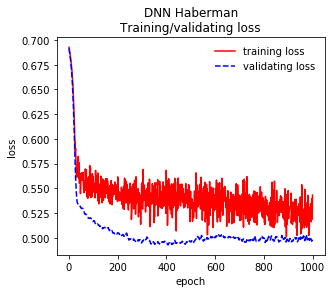

In [17]:
#----------------------------------------
# Summarize history for loss.

plt.figure('DNN Haberman loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('DNN Haberman' + '\n' + 'Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)
plt.show()


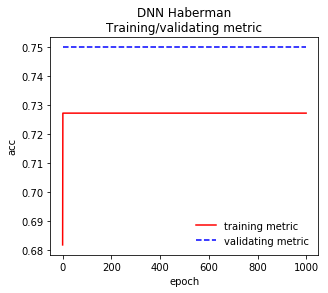

In [18]:
#----------------------------------------
# Summarize history for metric.

plt.figure('DNN Haberman metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('DNN Haberman' + '\n' + 'Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
plt.show()
